# Question 1.1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm


In [2]:
df = pd.read_csv('./A1_co2.txt', sep=' ')
df.head()

year  month      time     co2
0  1958      3  1958.208  315.71
1  1958      4  1958.292  317.45
2  1958      5  1958.375  317.50
3  1958      6  1958.458  317.10
4  1958      7  1958.542  315.86

> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [3]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/915935225.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


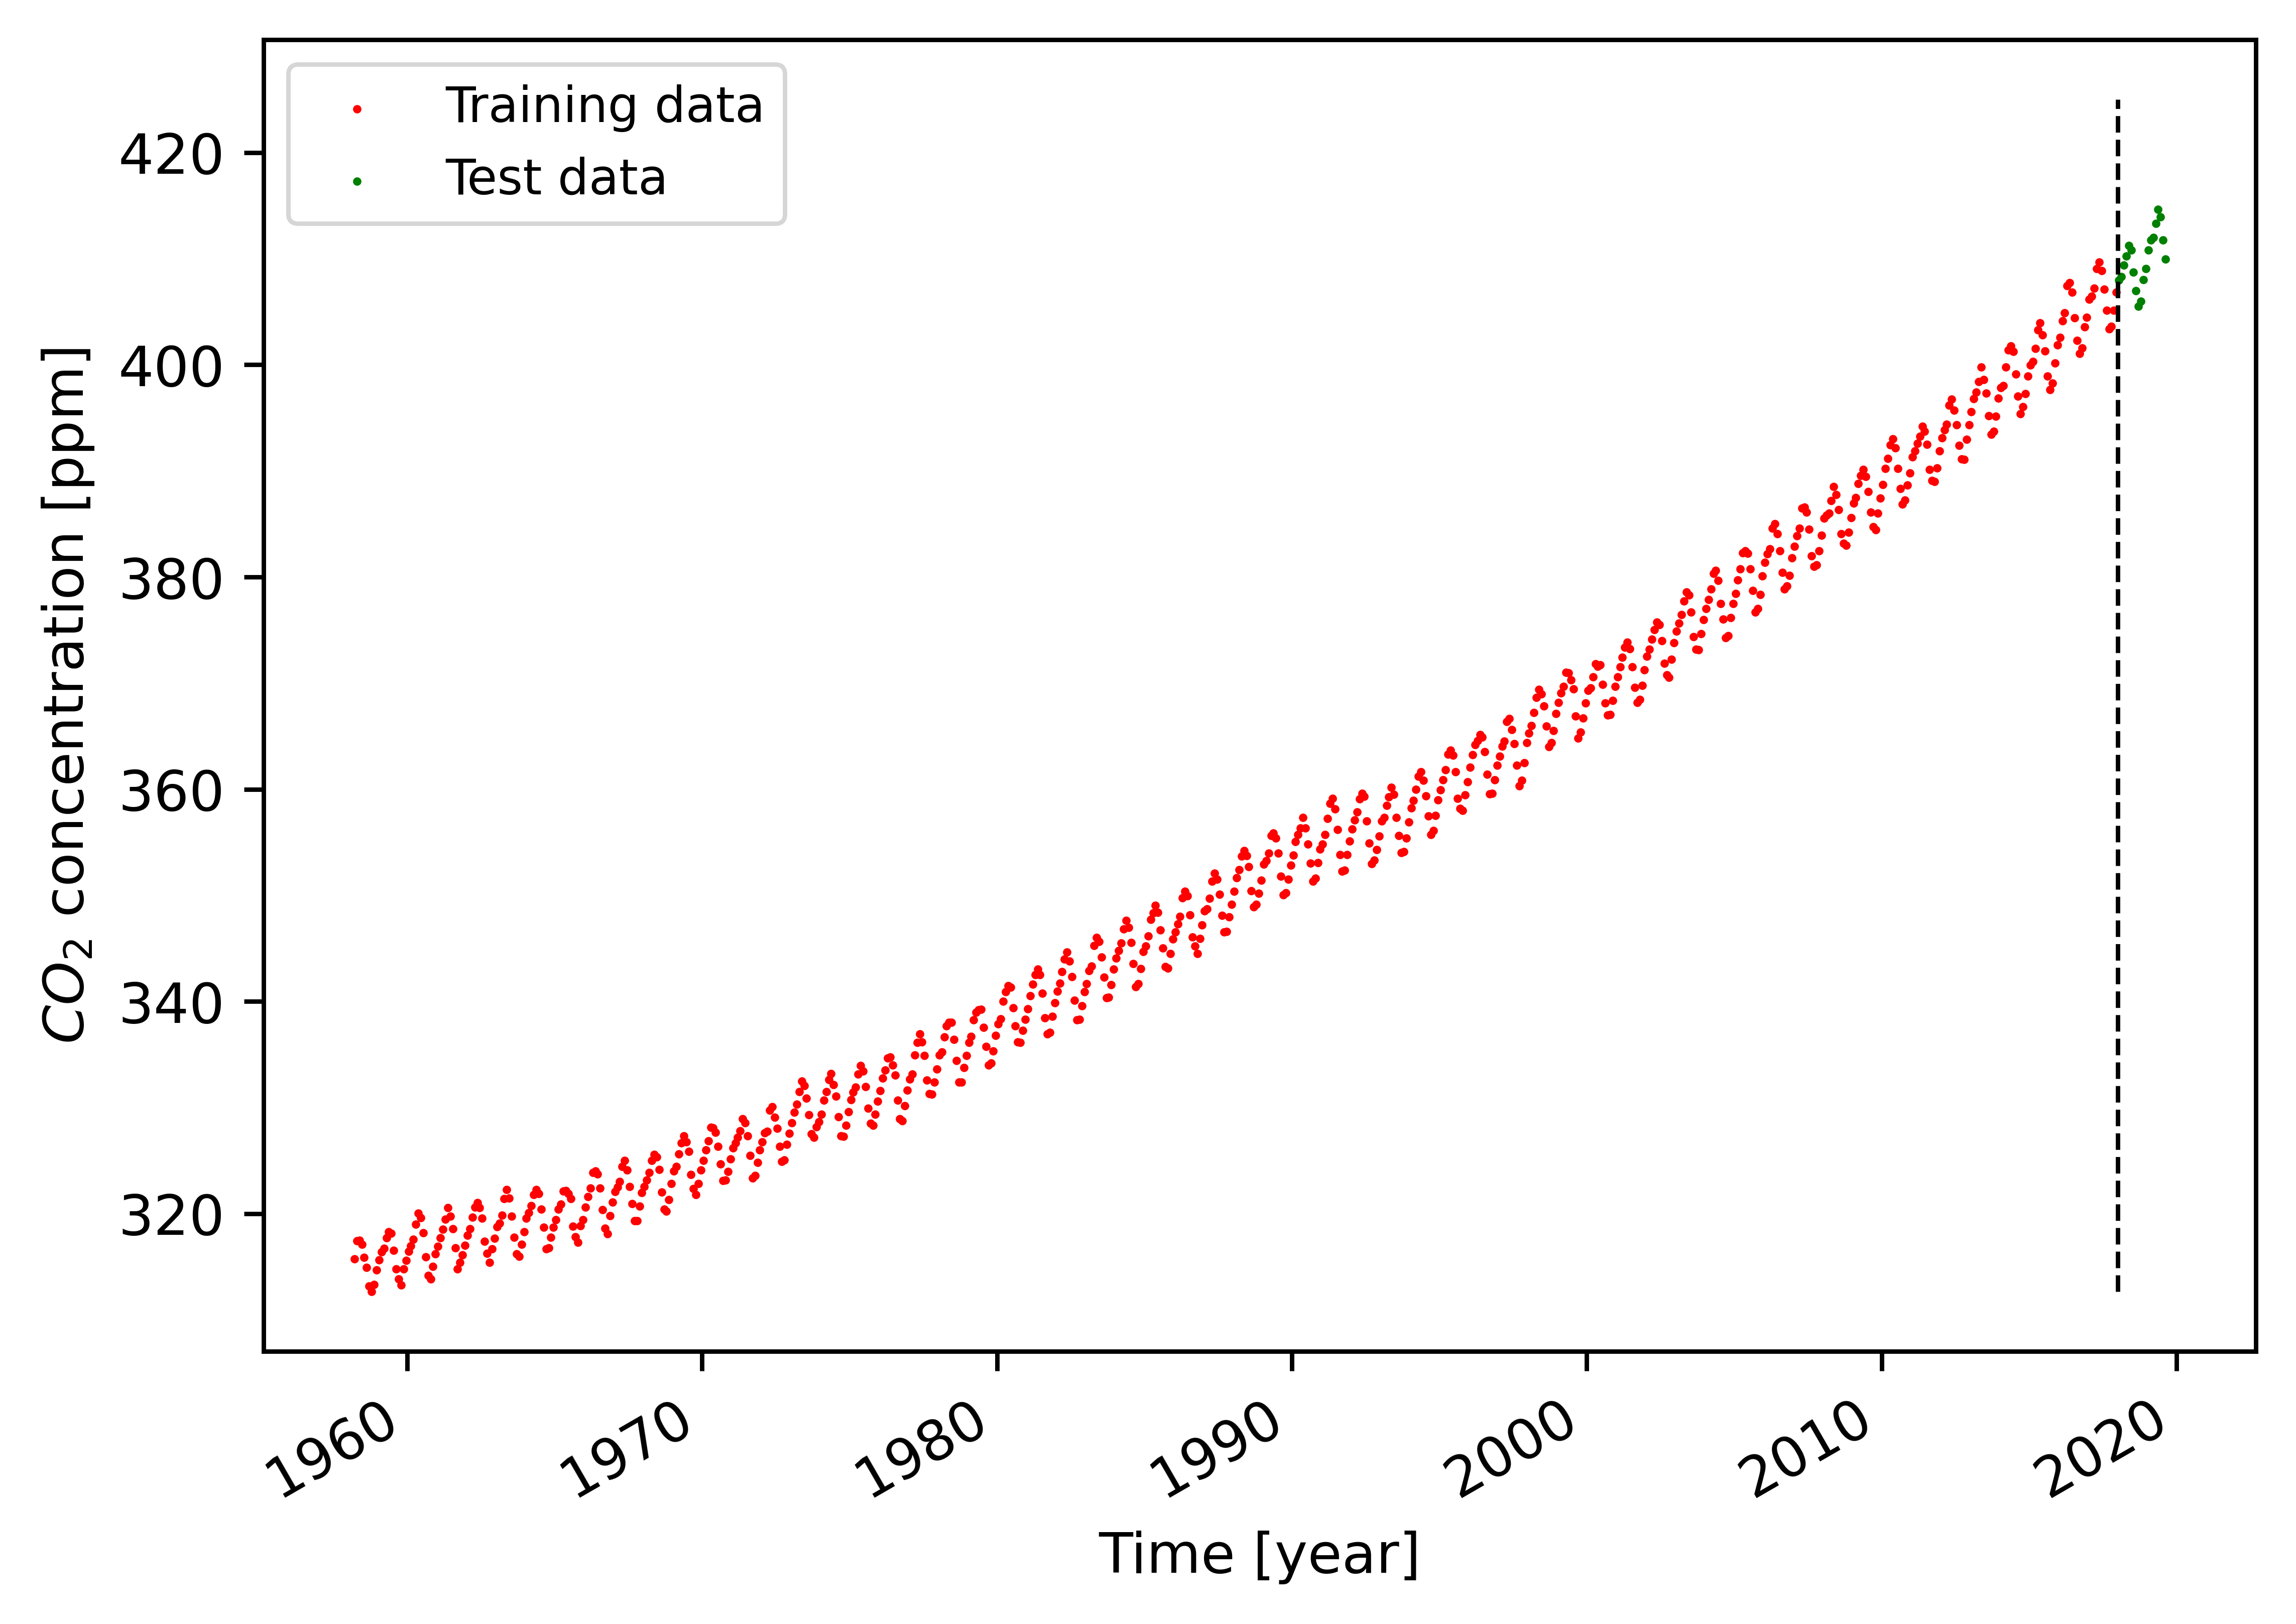

In [4]:
# Plot the data
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax.scatter(train["time"], train["co2"], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")

ax.vlines(2018, train["co2"].min(), 425, linestyles="dashed", colors="k")

ax.legend()

ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

# Question 1.2

## Question 1.2.1

In [5]:
MONTHS_IN_YEAR = 12

X_train = np.vstack(
    [
        np.ones_like(train.index),
        train.index,
        np.sin(2 * np.pi / MONTHS_IN_YEAR * train.index),
        np.cos(2 * np.pi / MONTHS_IN_YEAR * train.index),
    ]
).T

y_train = train["co2"].values

In [6]:
beta_ols, _, _, _ = np.linalg.lstsq(X_train, y_train)
beta_ols

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/2496290795.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_ols, _, _, _ = np.linalg.lstsq(X_train, y_train)


array([3.06928362e+02, 1.28374044e-01, 1.69090265e+00, 2.25306869e+00])

## Question 1.2.2

In [7]:
N, p = X_train.shape

residuals = y_train - X_train @ beta_ols

sigma_ols2 = np.sum(residuals ** 2) / (N - p)
sigma_ols2

12.185026694430931

In [8]:
sigma_ols = np.sqrt(sigma_ols2)
sigma_ols

3.490705758787316

In [9]:
var_beta_ols = sigma_ols2 * np.linalg.inv(X_train.T @ X_train)
var_beta_ols

array([[ 6.77484239e-02, -1.41638461e-04, -4.00049374e-04,
        -2.70584607e-04],
       [-1.41638461e-04,  3.95086363e-07,  9.35333307e-07,
         9.35333307e-07],
       [-4.00049374e-04,  9.35333307e-07,  3.39442373e-02,
        -7.99112497e-05],
       [-2.70584607e-04,  9.35333307e-07, -7.99112497e-05,
         3.39442373e-02]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/3628586960.py:2: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(var_beta_ols), annot=True, fmt=".2f")


<AxesSubplot: >

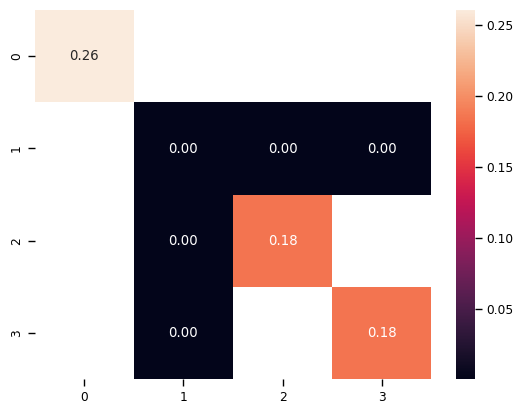

In [10]:
# Heatmap of the variance of the coefficients
sns.heatmap(np.sqrt(var_beta_ols), annot=True, fmt=".2f")

In [11]:
np.sqrt(np.diag(var_beta_ols))

array([0.26028527, 0.00062856, 0.18423962, 0.18423962])

## Question 1.2.3

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [12]:
def rho_matrix(rho: float, n: int):
    """
    Returns the covariance matrix for the observations of a stationary AR(1) process.
    """
    rhos = np.vander([rho], n, increasing=True)
    return scipy.linalg.toeplitz(rhos)


N, p = X_train.shape

# Initial guess of correlation structure
Sigma_wls = np.eye(N)

# Initial guess of coefficients
beta_wls = beta_ols

betas_wls = []

for _ in range(6):
    # E-step
    Sigma_inv = np.linalg.inv(Sigma_wls)

    H = np.linalg.inv(X_train.T @ Sigma_inv @ X_train) @ X_train.T @ Sigma_inv

    beta_new = H @ y_train

    # M-step
    residuals = y_train - X_train @ beta_new

    rho = np.corrcoef(residuals[:-1], residuals[1:])[0, 1] # 1-lag autocorrelation
    print(rho)

    Sigma_new = rho_matrix(rho, N)

    #if np.allclose(beta, beta_new, atol=1e-6) and np.allclose(Sigma, Sigma_new, atol=1e-6):
    #   break

    beta_wls = beta_new
    Sigma_wls = Sigma_new

    betas_wls.append(beta_wls)

beta_wls

0.9820921007263159
0.9822410526176385
0.9822427429486106
0.982242762307222
0.9822427625289551
0.9822427625314976


array([3.07470864e+02, 1.29839150e-01, 1.66890379e+00, 2.29457132e+00])

## Question 1.2.6

In [13]:
# Calculate the variance of the coefficients
sigma_wls2 = (residuals.T @ np.linalg.inv(Sigma_wls) @ residuals ) / (N - p)

var_beta_wls = np.linalg.inv(X_train.T @ np.linalg.inv(Sigma_wls) @ X_train) * sigma_wls2
var_beta_wls

array([[ 5.37440920e+00, -1.03811751e-02, -5.30015696e-04,
        -1.12349504e-03],
       [-1.03811751e-02,  2.89572528e-05,  2.30615165e-06,
         2.30615165e-06],
       [-5.30015696e-04,  2.30615165e-06,  4.57062027e-03,
         1.28481766e-05],
       [-1.12349504e-03,  2.30615165e-06,  1.28481766e-05,
         4.57062027e-03]])

In [14]:
sigma_wls2

12.268130156533738

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/1372562171.py:1: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(var_beta_wls), annot=True, fmt=".2f")


<AxesSubplot: >

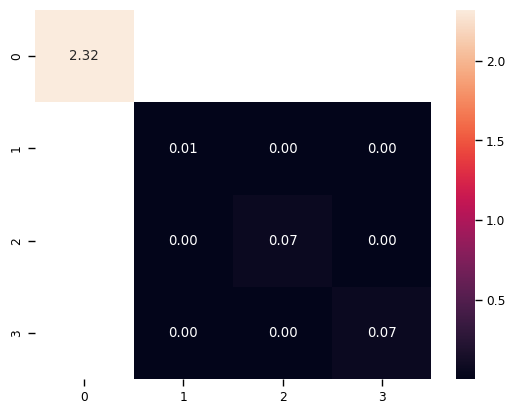

In [15]:
sns.heatmap(np.sqrt(var_beta_wls), annot=True, fmt=".2f")

In [16]:
np.sqrt(np.diag(var_beta_wls))

array([2.3182772 , 0.00538119, 0.06760636, 0.06760636])

In [17]:
beta_ols - beta_wls

array([-0.54250225, -0.00146511,  0.02199886, -0.04150264])

## Model comparison plot

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/946903035.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


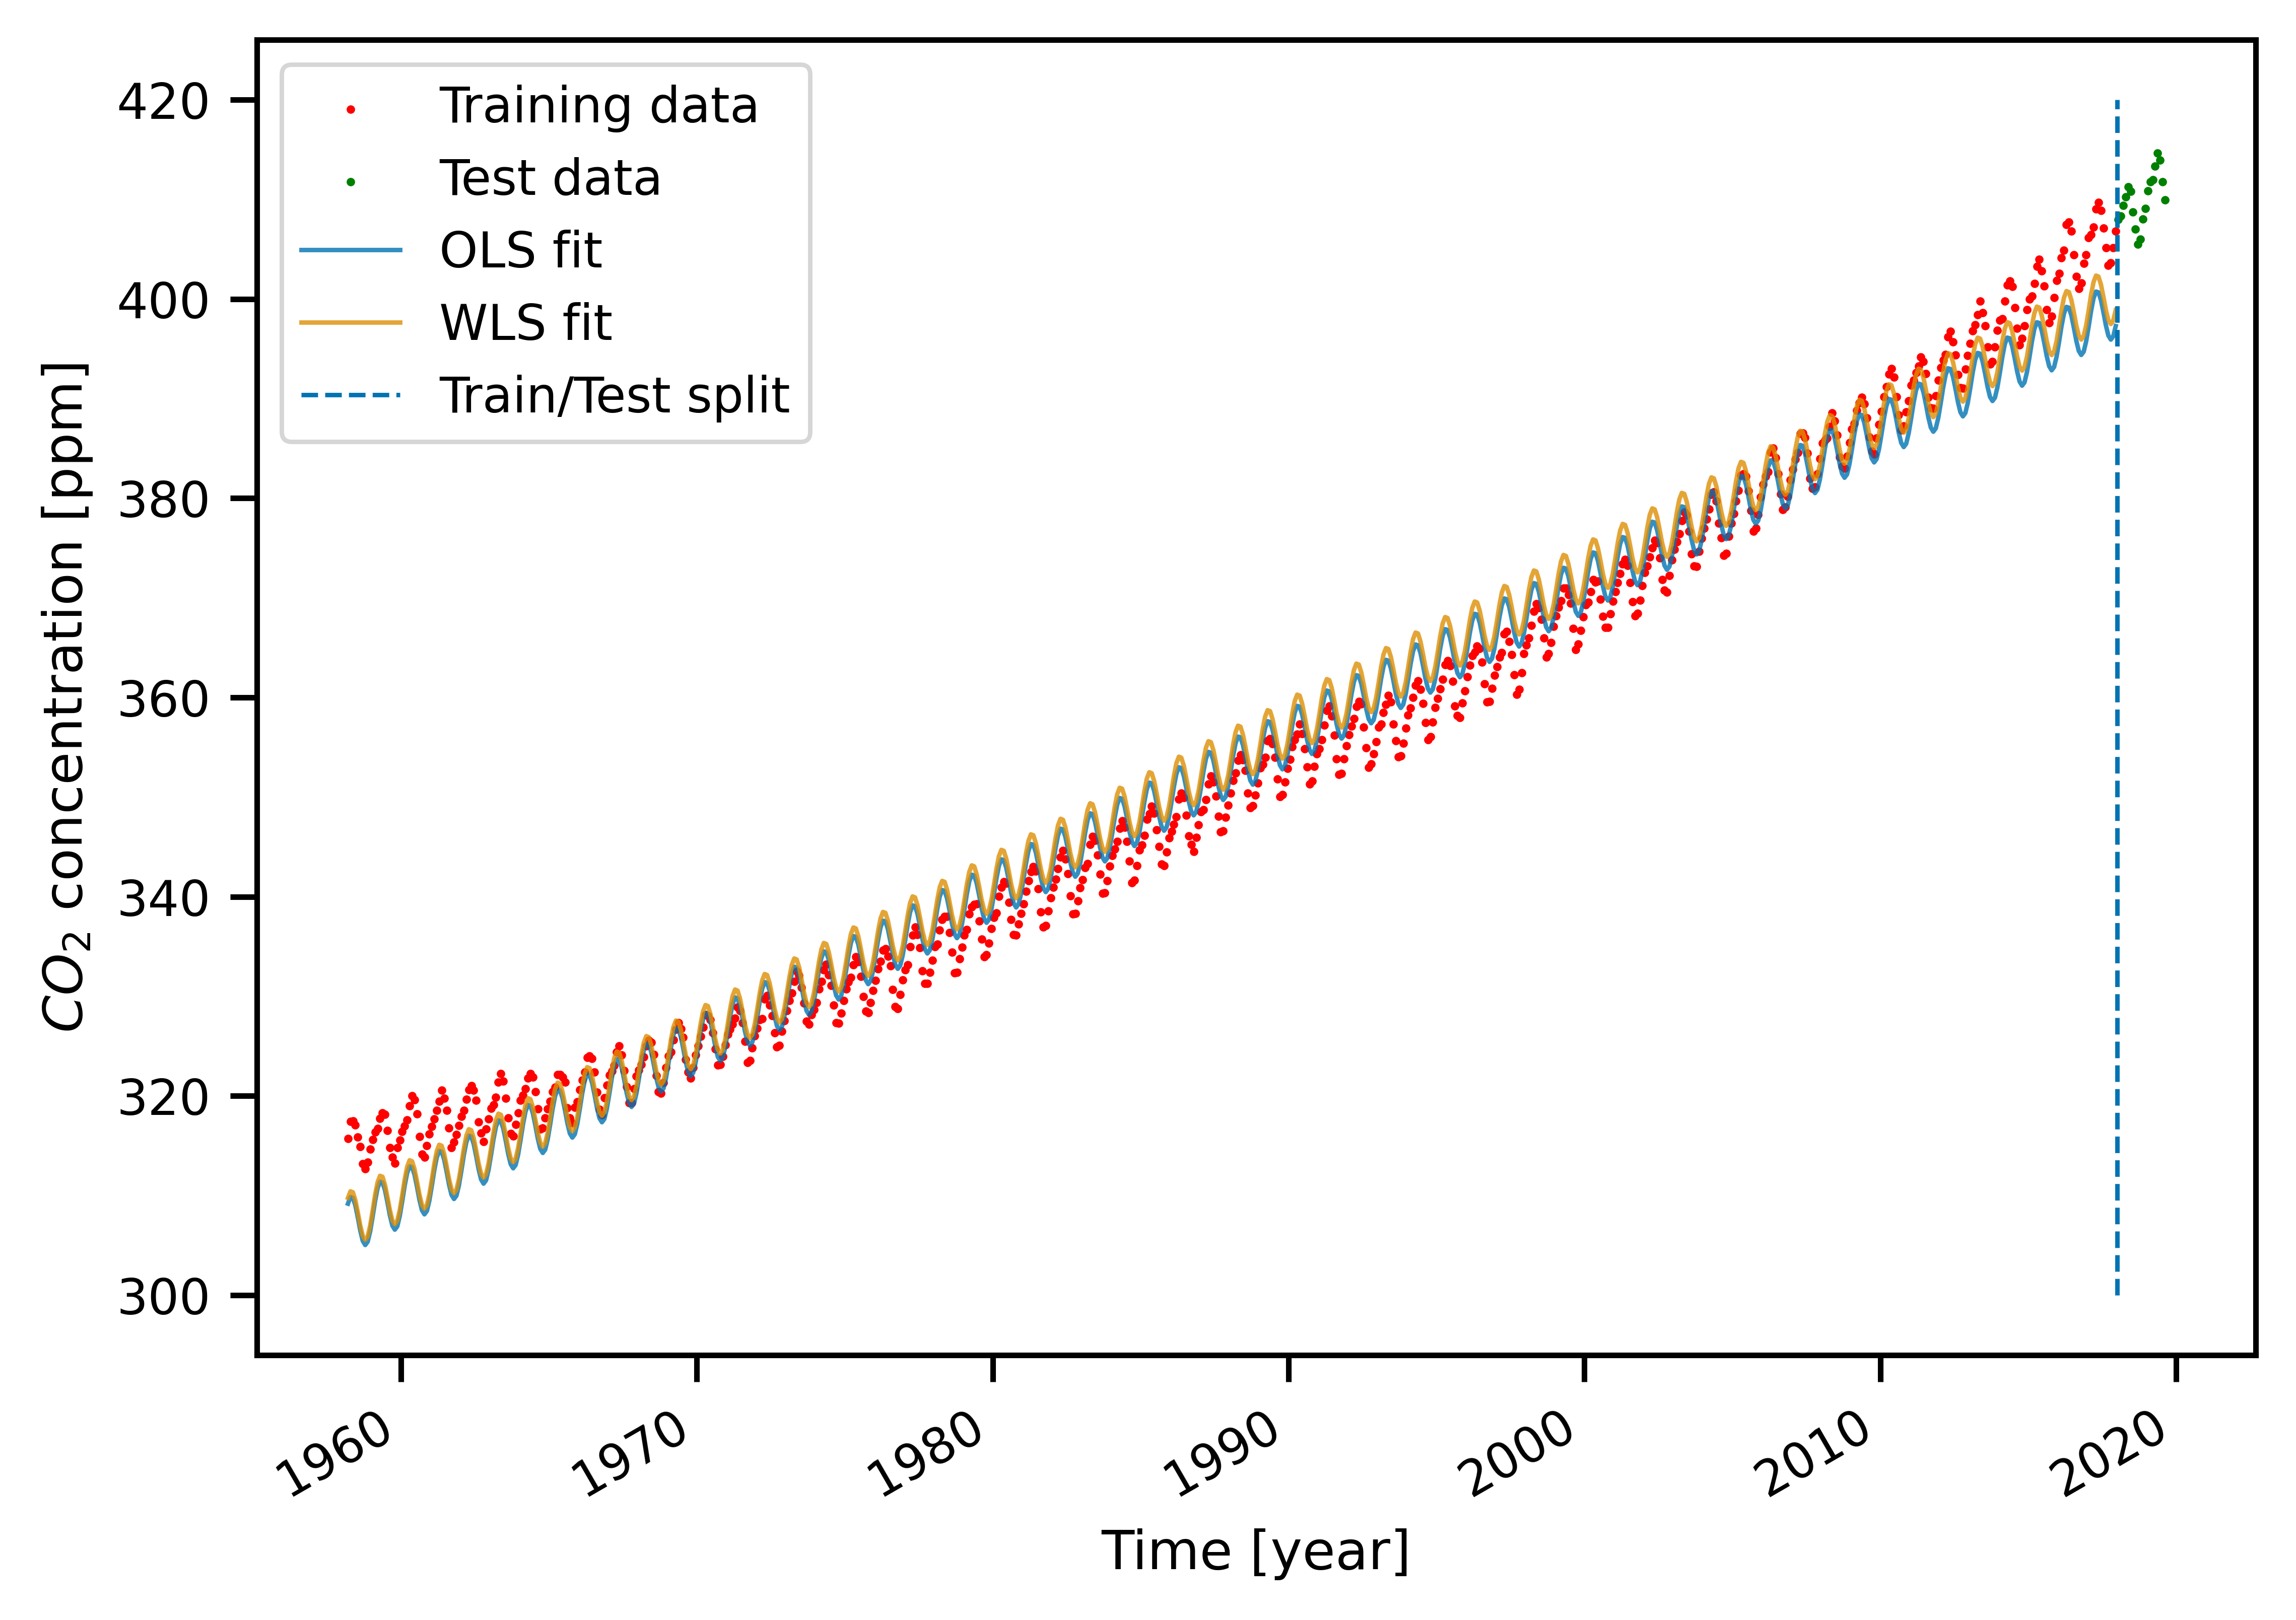

In [18]:
y_hat_ols = X_train @ beta_ols
y_hat_wls = X_train @ beta_wls

# Plot the train set and the fitted curves
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax.scatter(train["time"], train["co2"], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")
ax.plot(train["time"], y_hat_ols, label="OLS fit", alpha=0.8)
ax.plot(train["time"], y_hat_wls, label="WLS fit", alpha=0.8)

ax.vlines(2018, 300, 420, linestyles="dashed", label="Train/Test split")
ax.legend()


ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/2667701802.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


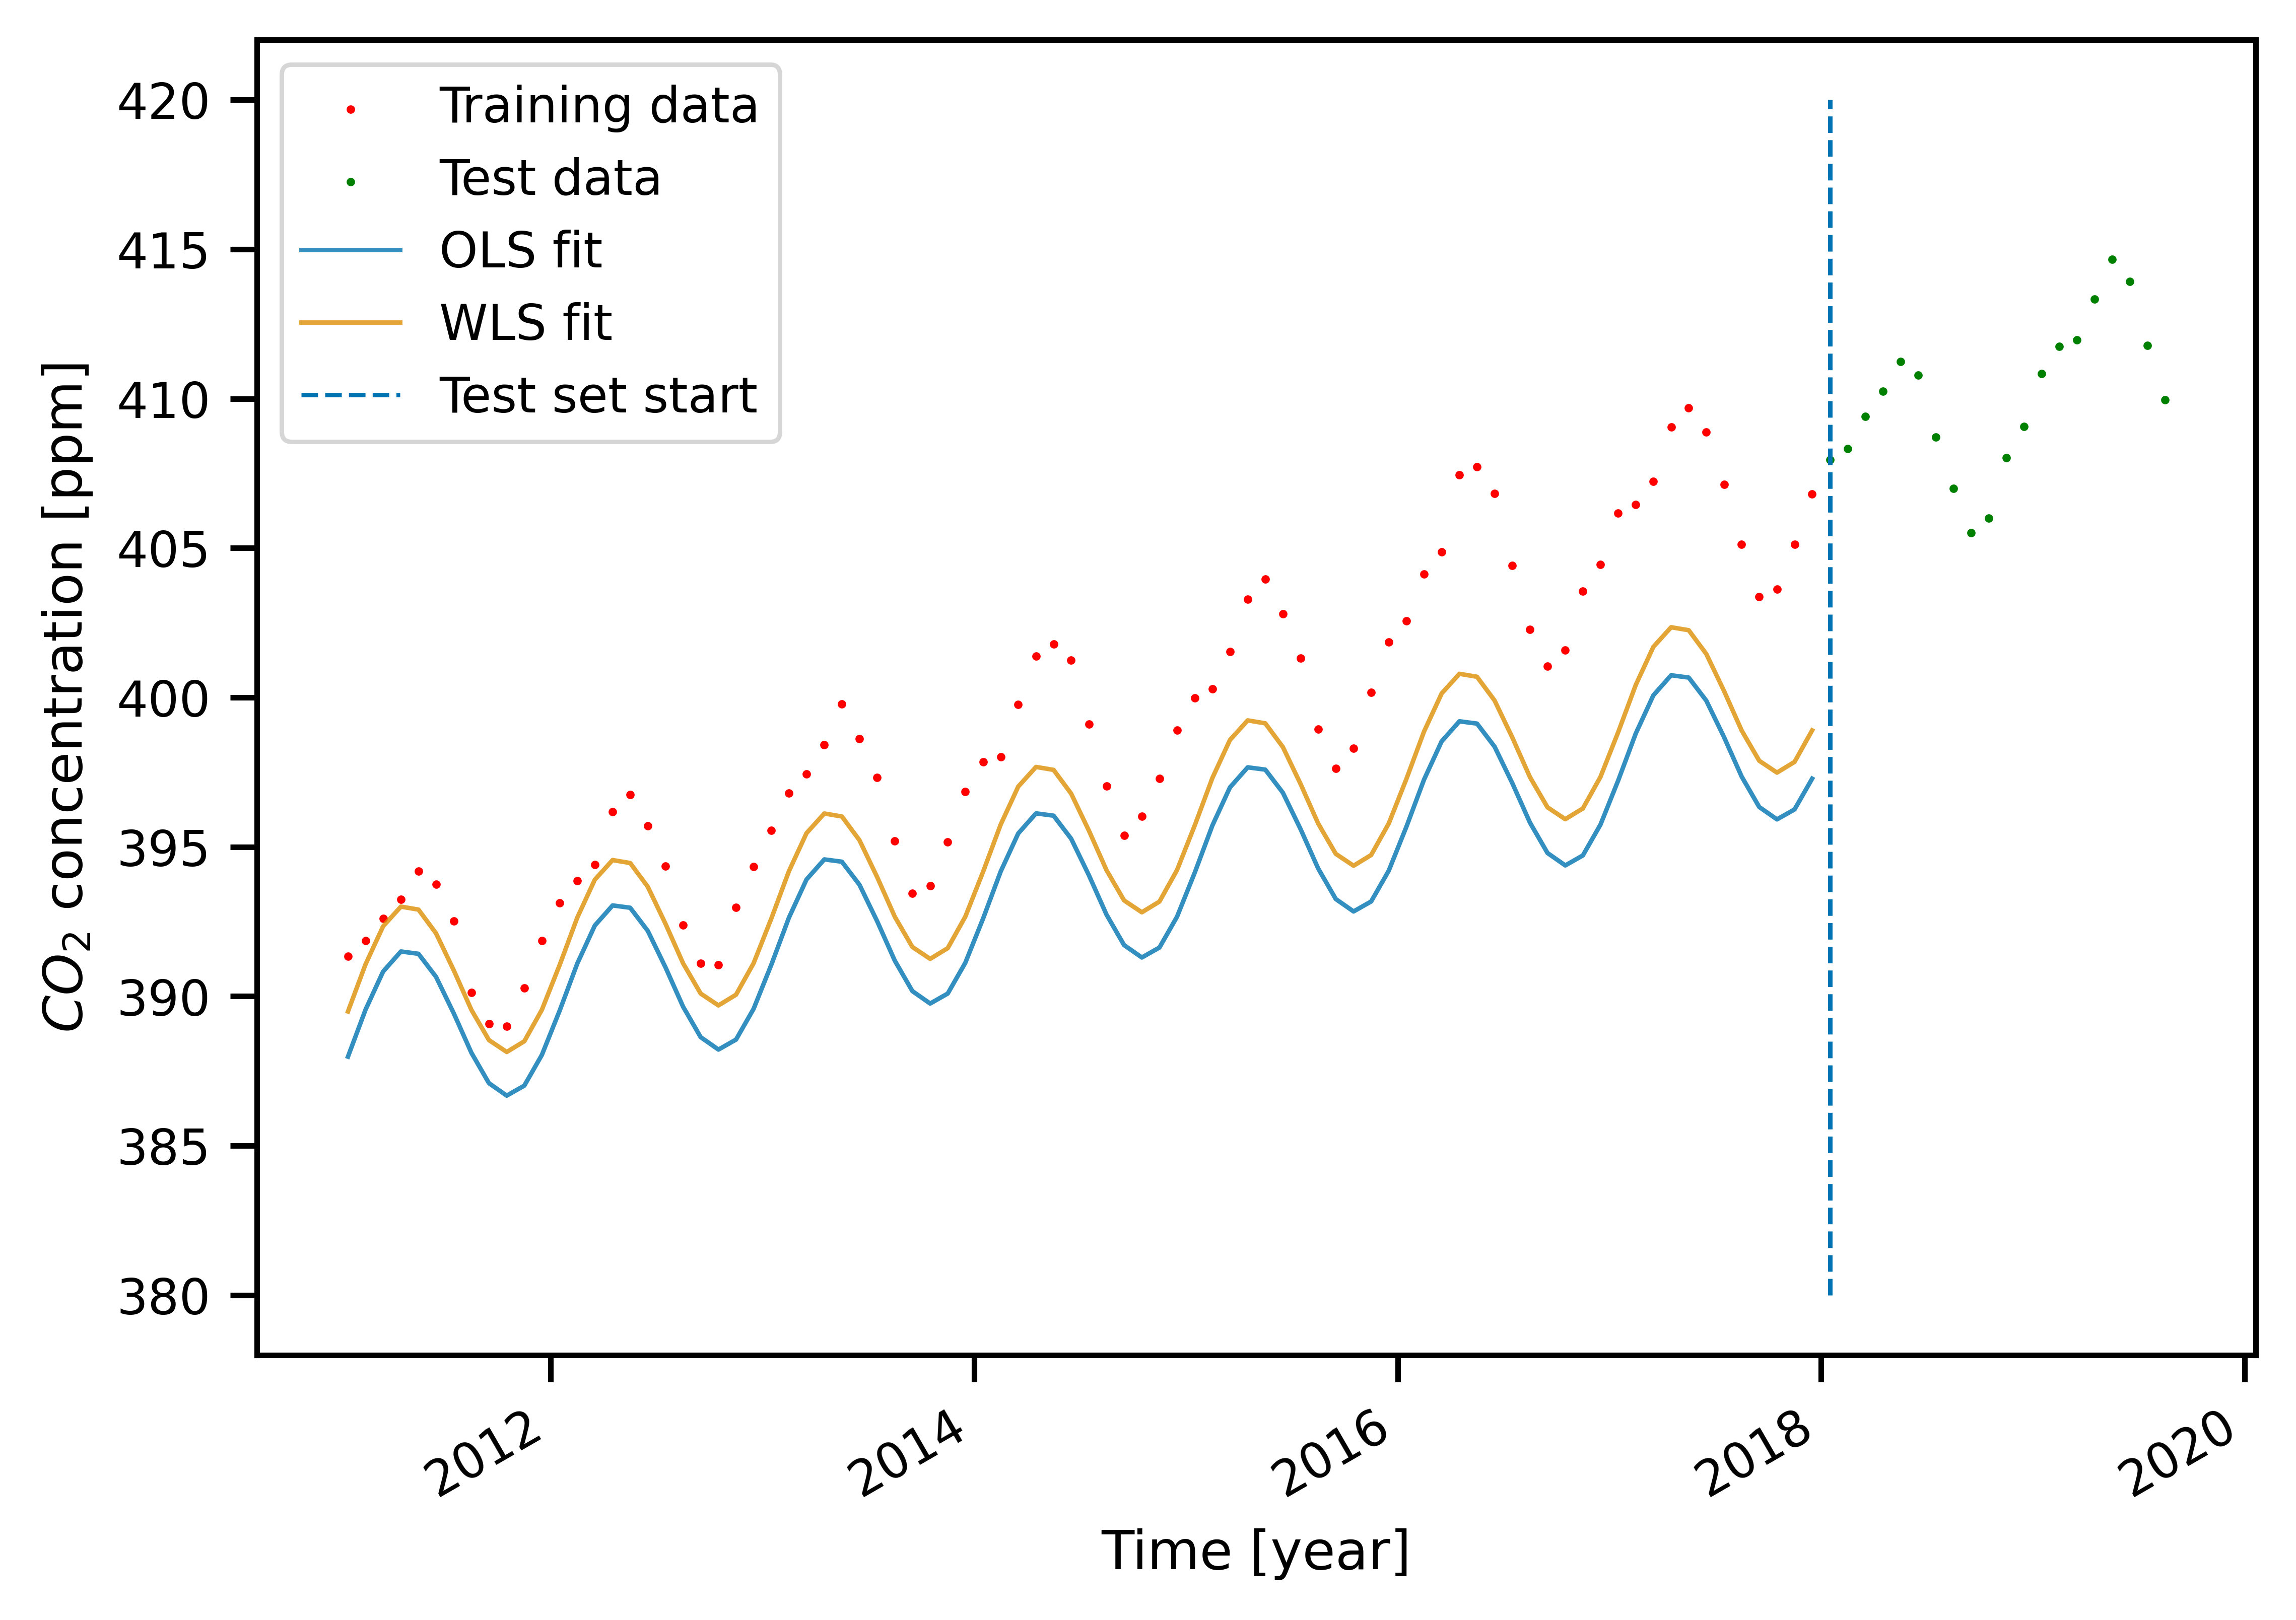

In [19]:
y_hat_ols = X_train @ beta_ols
y_hat_wls = X_train @ beta_wls

# Plot the train set and the fitted curves
fig, ax = plt.subplots(dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

idx_2010 = train["year"] > 2010

ax.scatter(train["time"][idx_2010], train["co2"][idx_2010], label="Training data", s=0.5, c="r")
ax.scatter(test["time"], test["co2"], label="Test data", s=0.5, c="g")
ax.plot(train["time"][idx_2010], y_hat_ols[idx_2010], label="OLS fit", alpha=0.8)
ax.plot(train["time"][idx_2010], y_hat_wls[idx_2010], label="WLS fit", alpha=0.8)

ax.vlines(test["time"].min(), 380, 420, linestyles="dashed", label="Test set start")

ax.legend()

ax.set_xlabel("Time [year]")
ax.set_ylabel("$CO_2$ concentration [ppm]")

fig.autofmt_xdate()
fig.show()

## Model comparison 

In [20]:
residuals_ols = train["co2"] - y_hat_ols
residuals_wls = train["co2"] - y_hat_wls

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_11218/1031458336.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


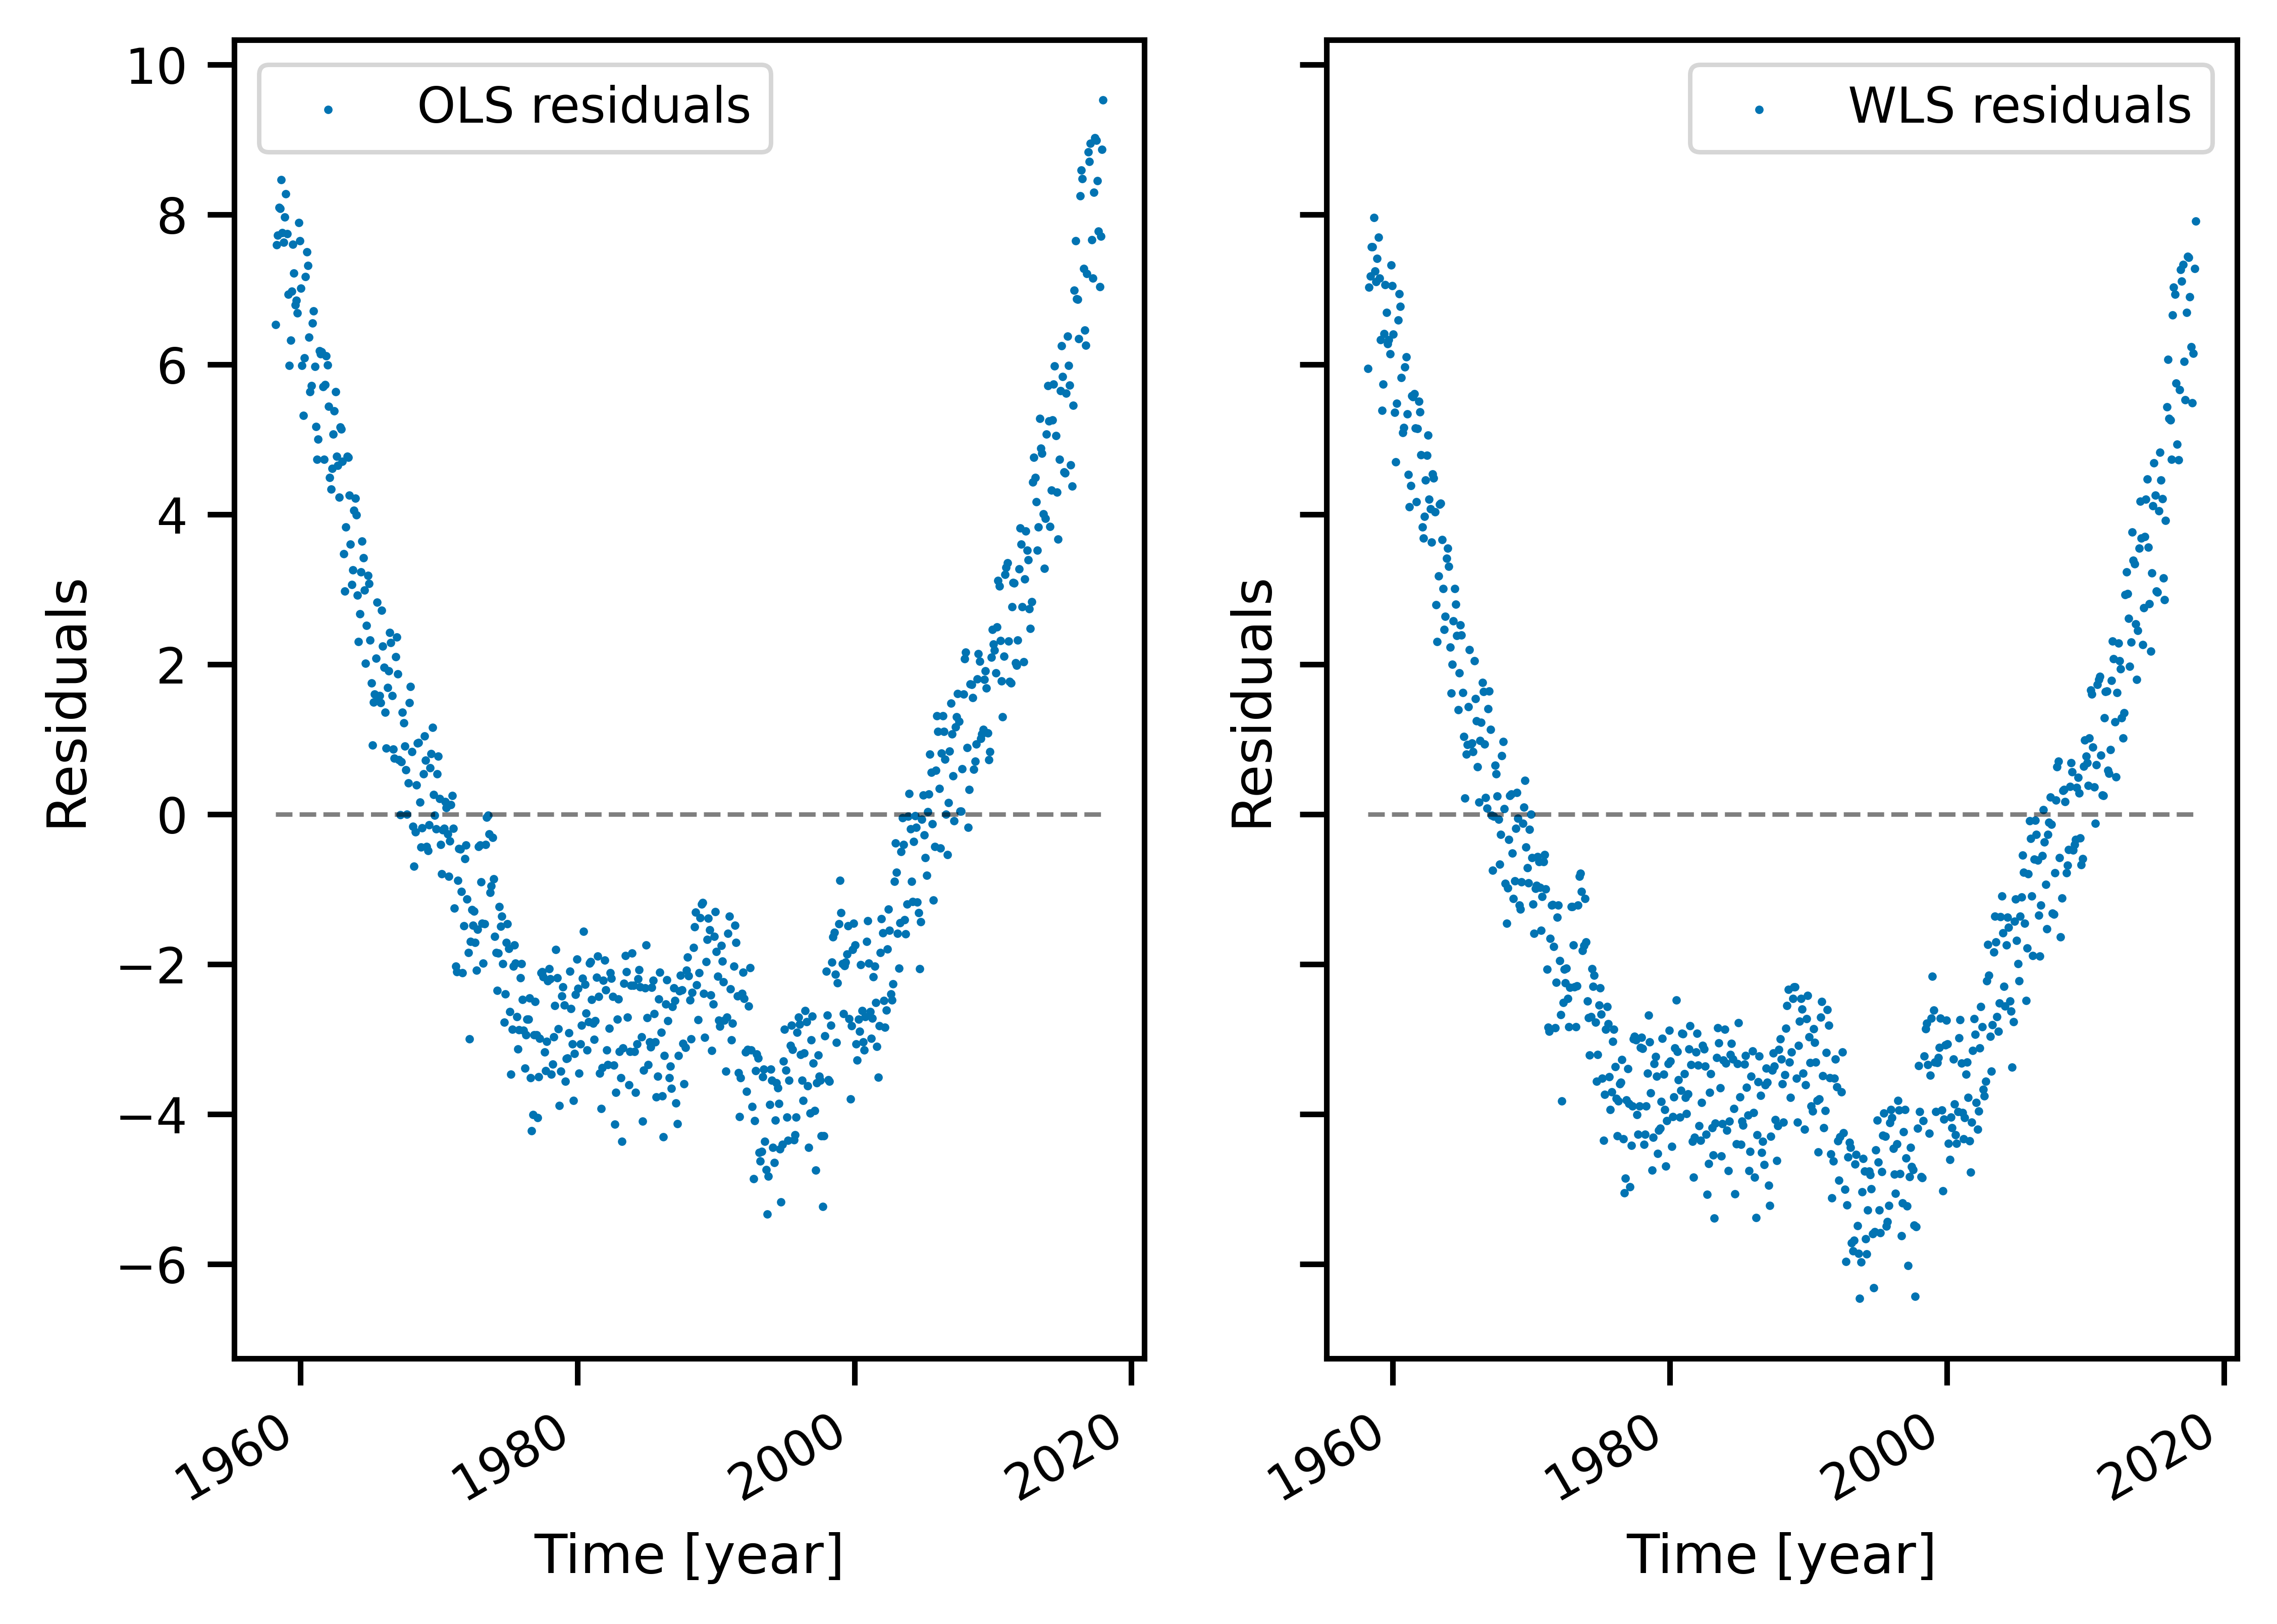

In [21]:
# Scatter plot of the residuals for the OLS and WLS fits
fig, ax = plt.subplots(ncols=2, sharey=True, dpi=800)

# Set the style
sns.set_context("paper", rc={"lines.linewidth": 0.8})
sns.set_palette("colorblind")

ax[0].scatter(train["time"], residuals_ols, label="OLS residuals", s=0.5,)
ax[1].scatter(train["time"], residuals_wls, label="WLS residuals", s=0.5)

ax[0].hlines(0, train["time"].min(), train["time"].max(), linestyle="--", alpha=0.5, colors="k")
ax[1].hlines(0, train["time"].min(), train["time"].max(), linestyle="--", alpha=0.5, colors="k")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("Time [year]")
ax[1].set_xlabel("Time [year]")

ax[0].set_ylabel("Residuals")
ax[1].set_ylabel("Residuals")

fig.autofmt_xdate()
fig.show()

# Question 1.3

In [22]:
plt.rc("axes", axisbelow=True)
plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.figsize"] = (9, 4)
sns.set_palette("colorblind")

## Question 1.3.2

Filter the data with the chosen model.

In [23]:
# Load data

year, month, time, co2 = df.values.T

year = year.astype(int)
month = month.astype(int)

# Index data by indices. 12 months per year
# NOTE: There is a constant time delta between each data point,
#  so indexing directly by indices is fine.
p = 12

# Split into test and train
test_idx = year >= 2018
time_test, co2_test = time[test_idx], co2[test_idx]
time_train, co2_train = time[~test_idx], co2[~test_idx]
y_train = co2_train[:, None]

train_n = len(time_train)
test_n = len(time_test)

param_n = 4

In [24]:
def llt_pred_interval(y_pred, t, F, f, var, alpha=0.05):
    return y_pred + np.array([1, -1]) * stats.t.ppf(
        1 - alpha / 2, t - param_n
    ) * np.sqrt(var) * np.sqrt(1 + f.T @ np.linalg.inv(F) @ f)


def f(t):
    return np.array(
        [
            [
                1,
                t,
                np.sin(2 * np.pi / p * t),
                np.cos(2 * np.pi / p * t),
            ]
        ]
    ).T


def llt_predict(start=10, lamb=0.9):
    assert start > 0, "Start must be greater than 0"

    # Createnp.linalg.inverse transition matrix
    L_inv = np.linalg.inv(
        np.array(
            [
                [1, 0, 0, 0],
                [1, 1, 0, 0],
                [0, 0, np.cos(2 * np.pi / p), np.sin(2 * np.pi / p)],
                [0, 0, -np.sin(2 * np.pi / p), np.cos(2 * np.pi / p)],
            ]
        )
    )

    # Create design matrix for t'th time step
    f_0 = f(0)

    F = np.zeros((param_n, param_n))
    h = np.zeros((param_n, 1))

    # Store predictions and variances
    y_pred_train = []
    y_pred_train_interval = []
    y_pred_train_mean = []
    y_pred_train_var = []
    y_pred_train_var_sum = 0
    thetas = []

    # Go through each data point and make one-step predictions
    for i in range(0, train_n):
        # If burn-in period is over, make predictions
        if i >= start:
            F_inv = np.linalg.inv(F)

            # Calculate parameters for previous time step
            theta = F_inv @ h

            # Make one step prediction using parameters
            #  from previous data to predict current data.
            y_pred = f(1).T @ theta

            # Calculate noise variance from next prediction
            y_pred_train_var_sum += (
                (y_train[i, 0] - y_pred[0]) ** 2 / (1 + f(1).T @ F_inv @ f(1))
            )[0, 0]
            y_pred_train_var.append(y_pred_train_var_sum / (i - start + 1))

            # Store predictions
            y_pred_train.append(y_pred[0, 0])
            y_pred_train_mean.append(theta[0, 0])
            thetas.append(theta)

            # Store prediction interval
            y_pred_train_interval.append(
                llt_pred_interval(y_pred, i - 1, F, f(1), y_pred_train_var[-1], 0.05)
            )

        # Update F and h
        F = F + lamb**i * f(-i) @ f(-i).T
        h = lamb * L_inv @ h + f_0 @ y_train[i : i + 1]

    # Calculate final parameters
    theta = np.linalg.inv(F) @ h
    thetas.append(theta)

    # Make predictions for test data
    y_pred_test = np.array([f(t + 1).squeeze() for t in range(test_n)]) @ theta

    # Make intervals for test data
    y_pred_test_interval = np.array(
        [
            llt_pred_interval(
                y_pred_test[t], train_n, F, f(t + 1), y_pred_train_var[-1], 0.05
            )
            for t in range(test_n)
        ]
    ).squeeze()

    # Return a big mess
    return (
        np.array(y_pred_train),
        np.array(y_pred_train_interval).squeeze(),
        np.array(y_pred_train_mean),
        np.array(y_pred_train_var),
        y_pred_test,
        y_pred_test_interval,
    )


# Amount of data to skip predictions for
burn_in_1 = 10

# Retrieve predictions
(
    llt_y_pred_train,
    llt_y_pred_train_interval,
    llt_y_pred_train_mean,
    llt_y_pred_train_var,
    llt_y_pred_test,
    llt_y_pred_test_interval,
) = llt_predict(start=burn_in_1, lamb=0.9)

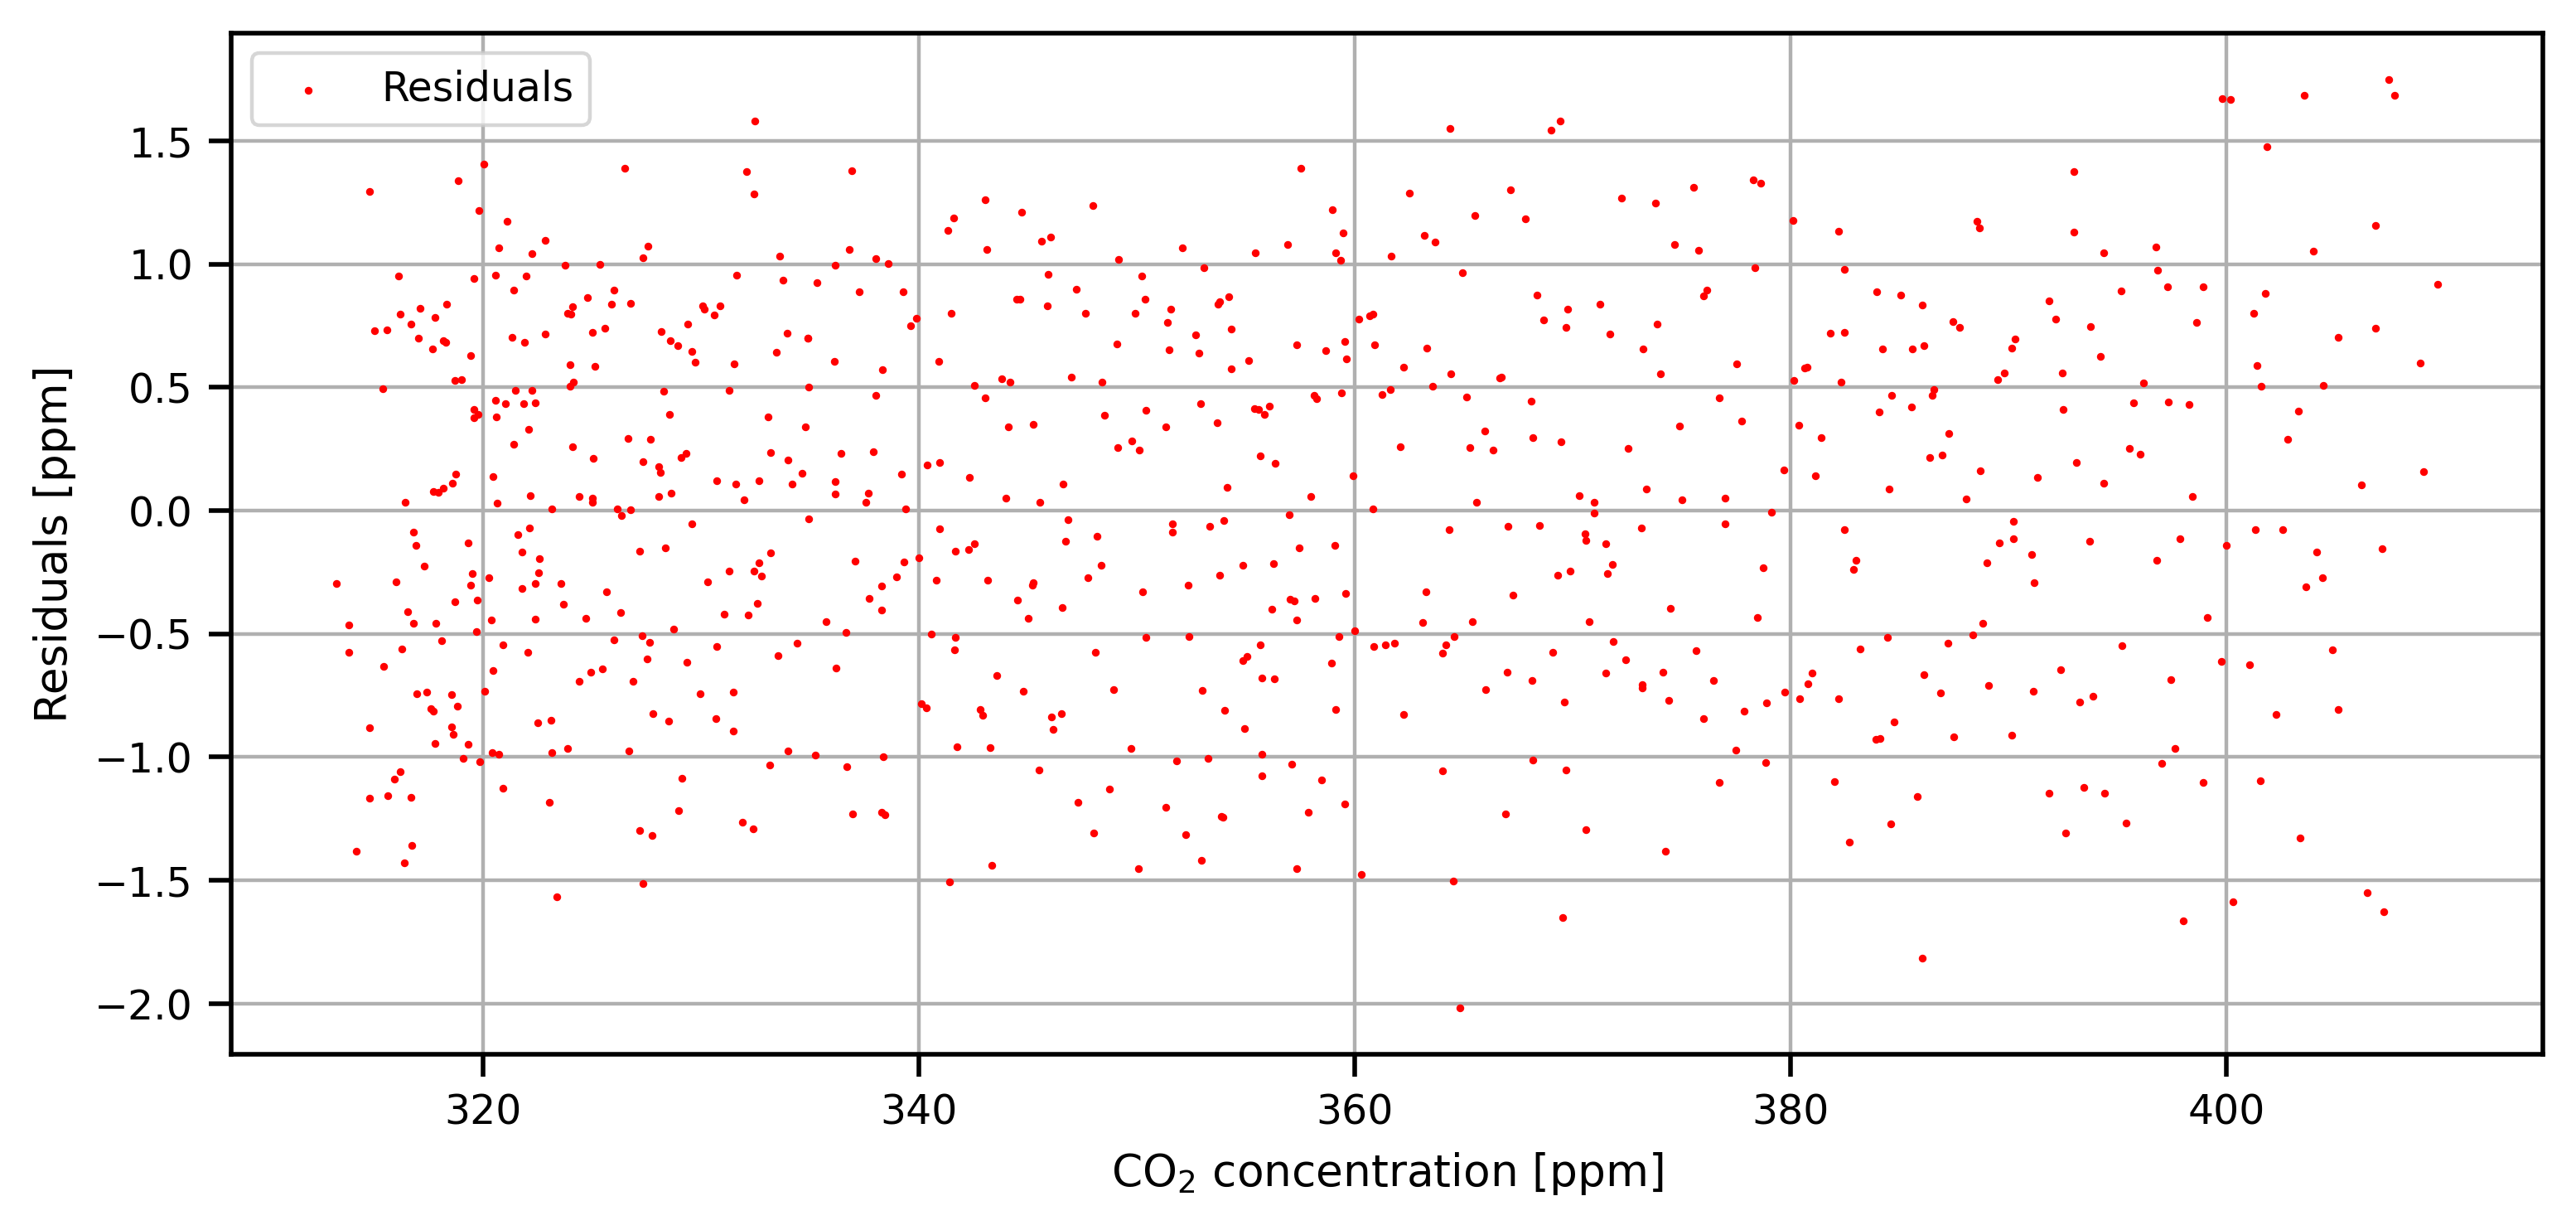

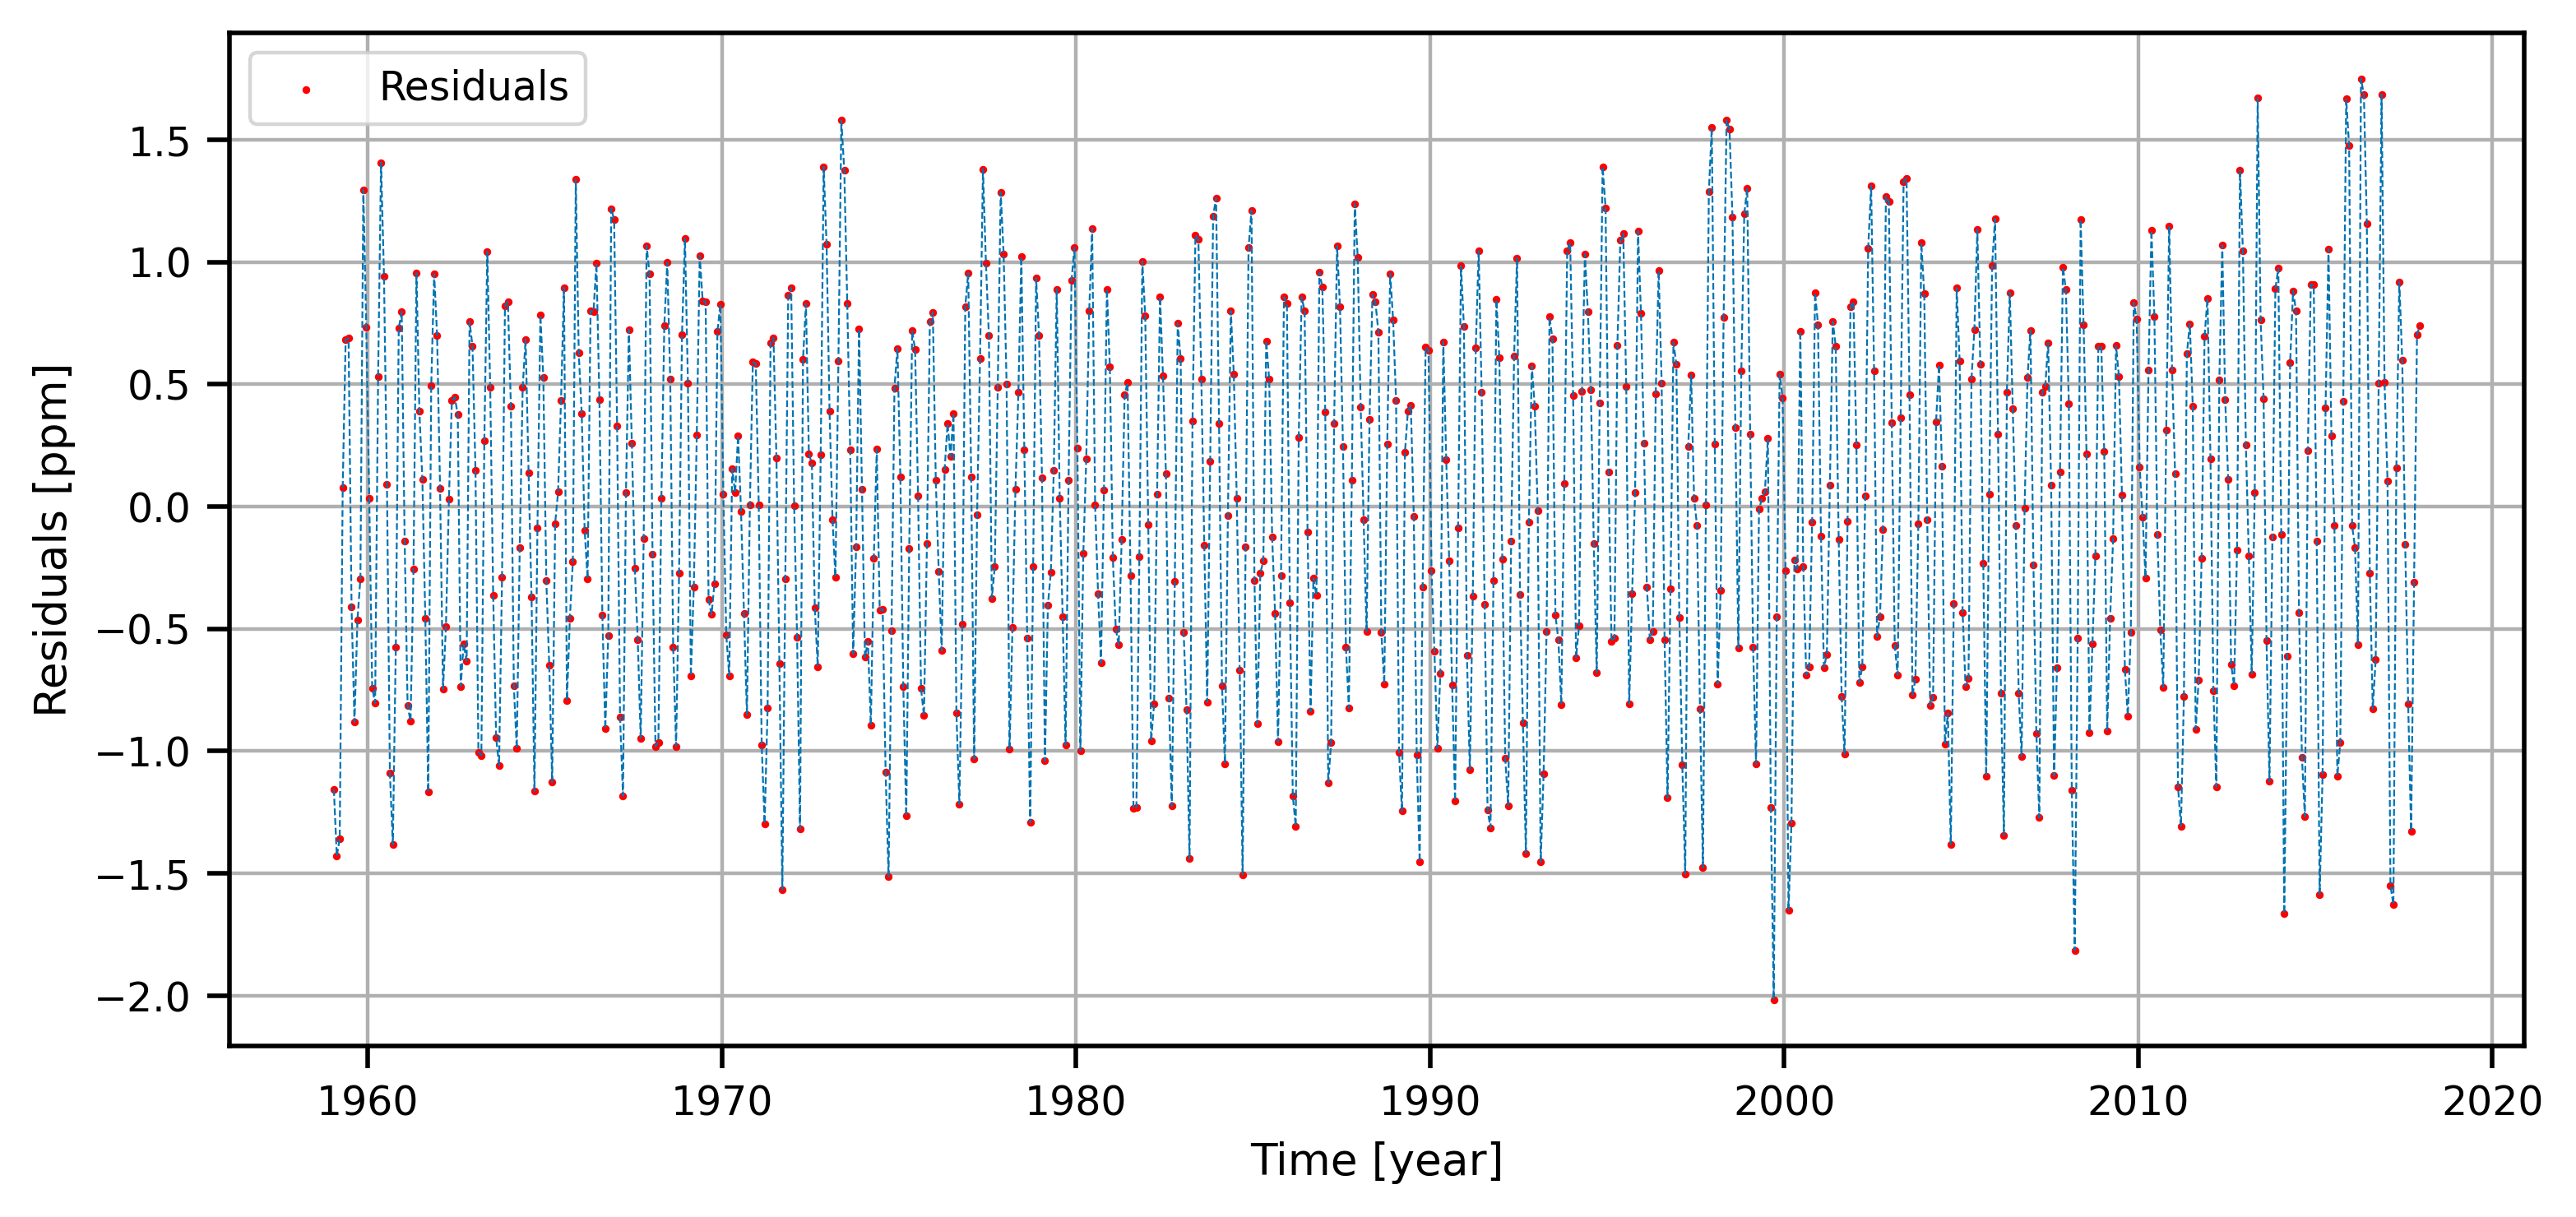

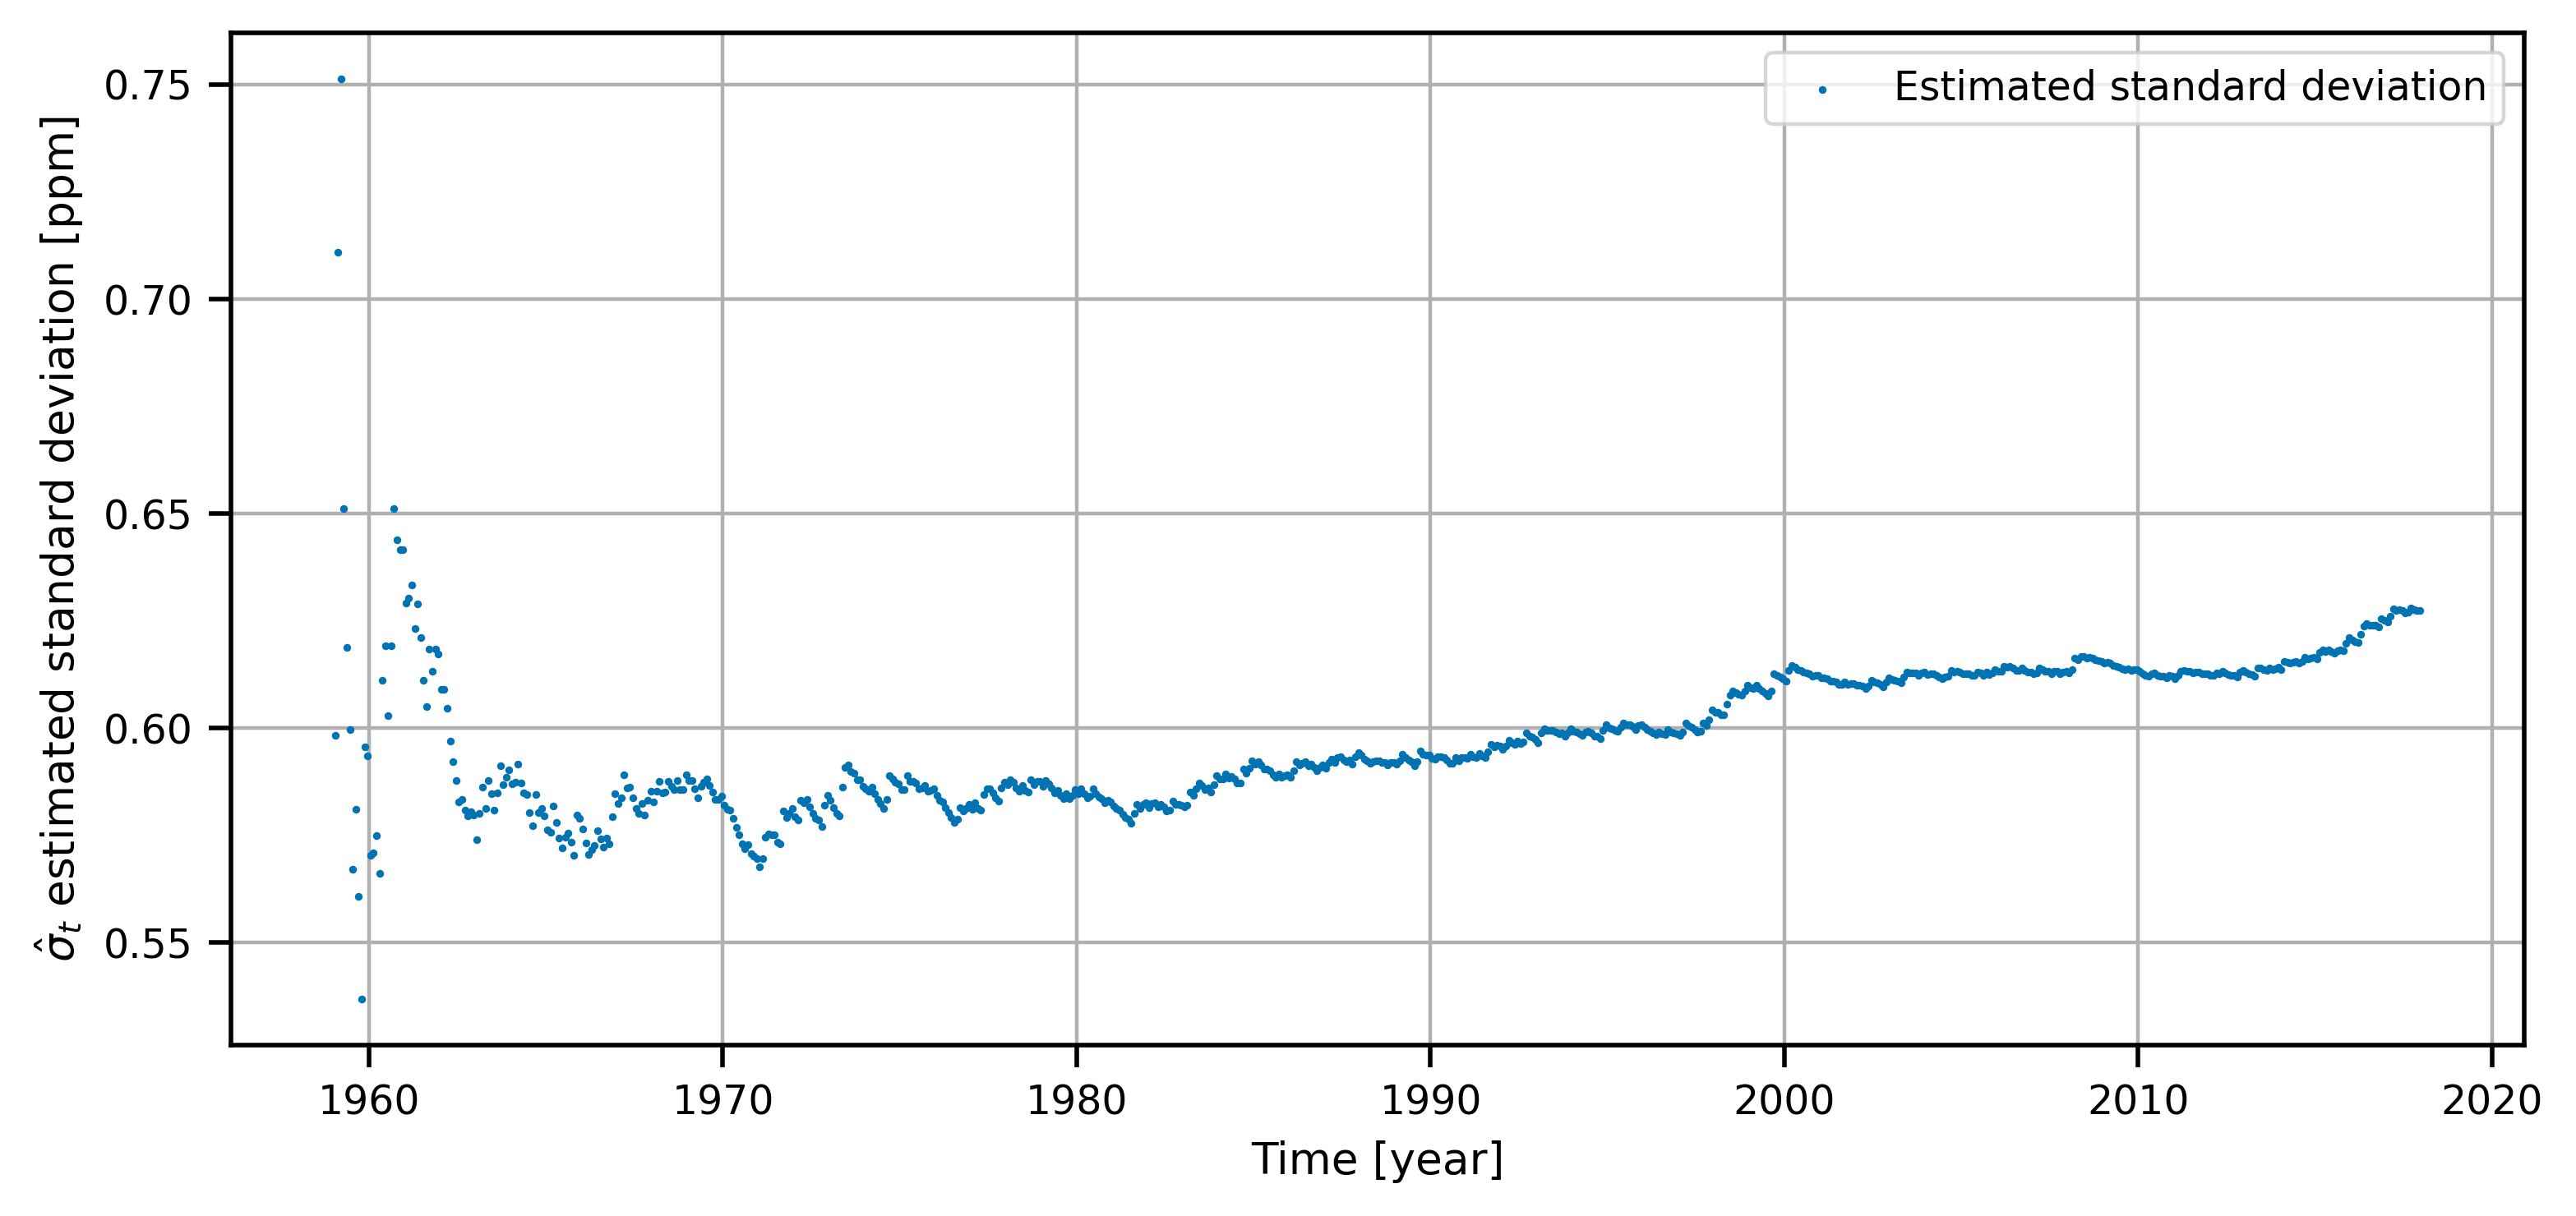

0.6273878545097442


In [25]:
llt_residuals = y_train[burn_in_1:, 0] - llt_y_pred_train

# Plot residuals as function of y
plt.scatter(y_train[burn_in_1:, 0], llt_residuals, s=0.8, c='r', label='Residuals')

plt.xlabel("CO$_2$ concentration [ppm]")
plt.ylabel("Residuals [ppm]")

plt.legend()
plt.grid()

plt.show()


# Plot residuals as function of time
plt.plot(time_train[burn_in_1:], llt_residuals, '--', linewidth=0.4)
plt.scatter(time_train[burn_in_1:], llt_residuals, c='r', s=0.8, label='Residuals')

plt.xlabel("Time [year]")
plt.ylabel("Residuals [ppm]")

plt.legend()
plt.grid()

plt.show()


# Plot variance
plt.scatter(time_train[burn_in_1:], np.sqrt(llt_y_pred_train_var), s=0.8, label='Estimated standard deviation')

plt.xlabel("Time [year]")
plt.ylabel("$\hat \sigma_t$ estimated standard deviation [ppm]")

plt.legend()
plt.grid()

plt.show()

print(np.sqrt(llt_y_pred_train_var[-1]))

# 1.4


100%|██████████| 1000/1000 [01:03<00:00, 15.79it/s]


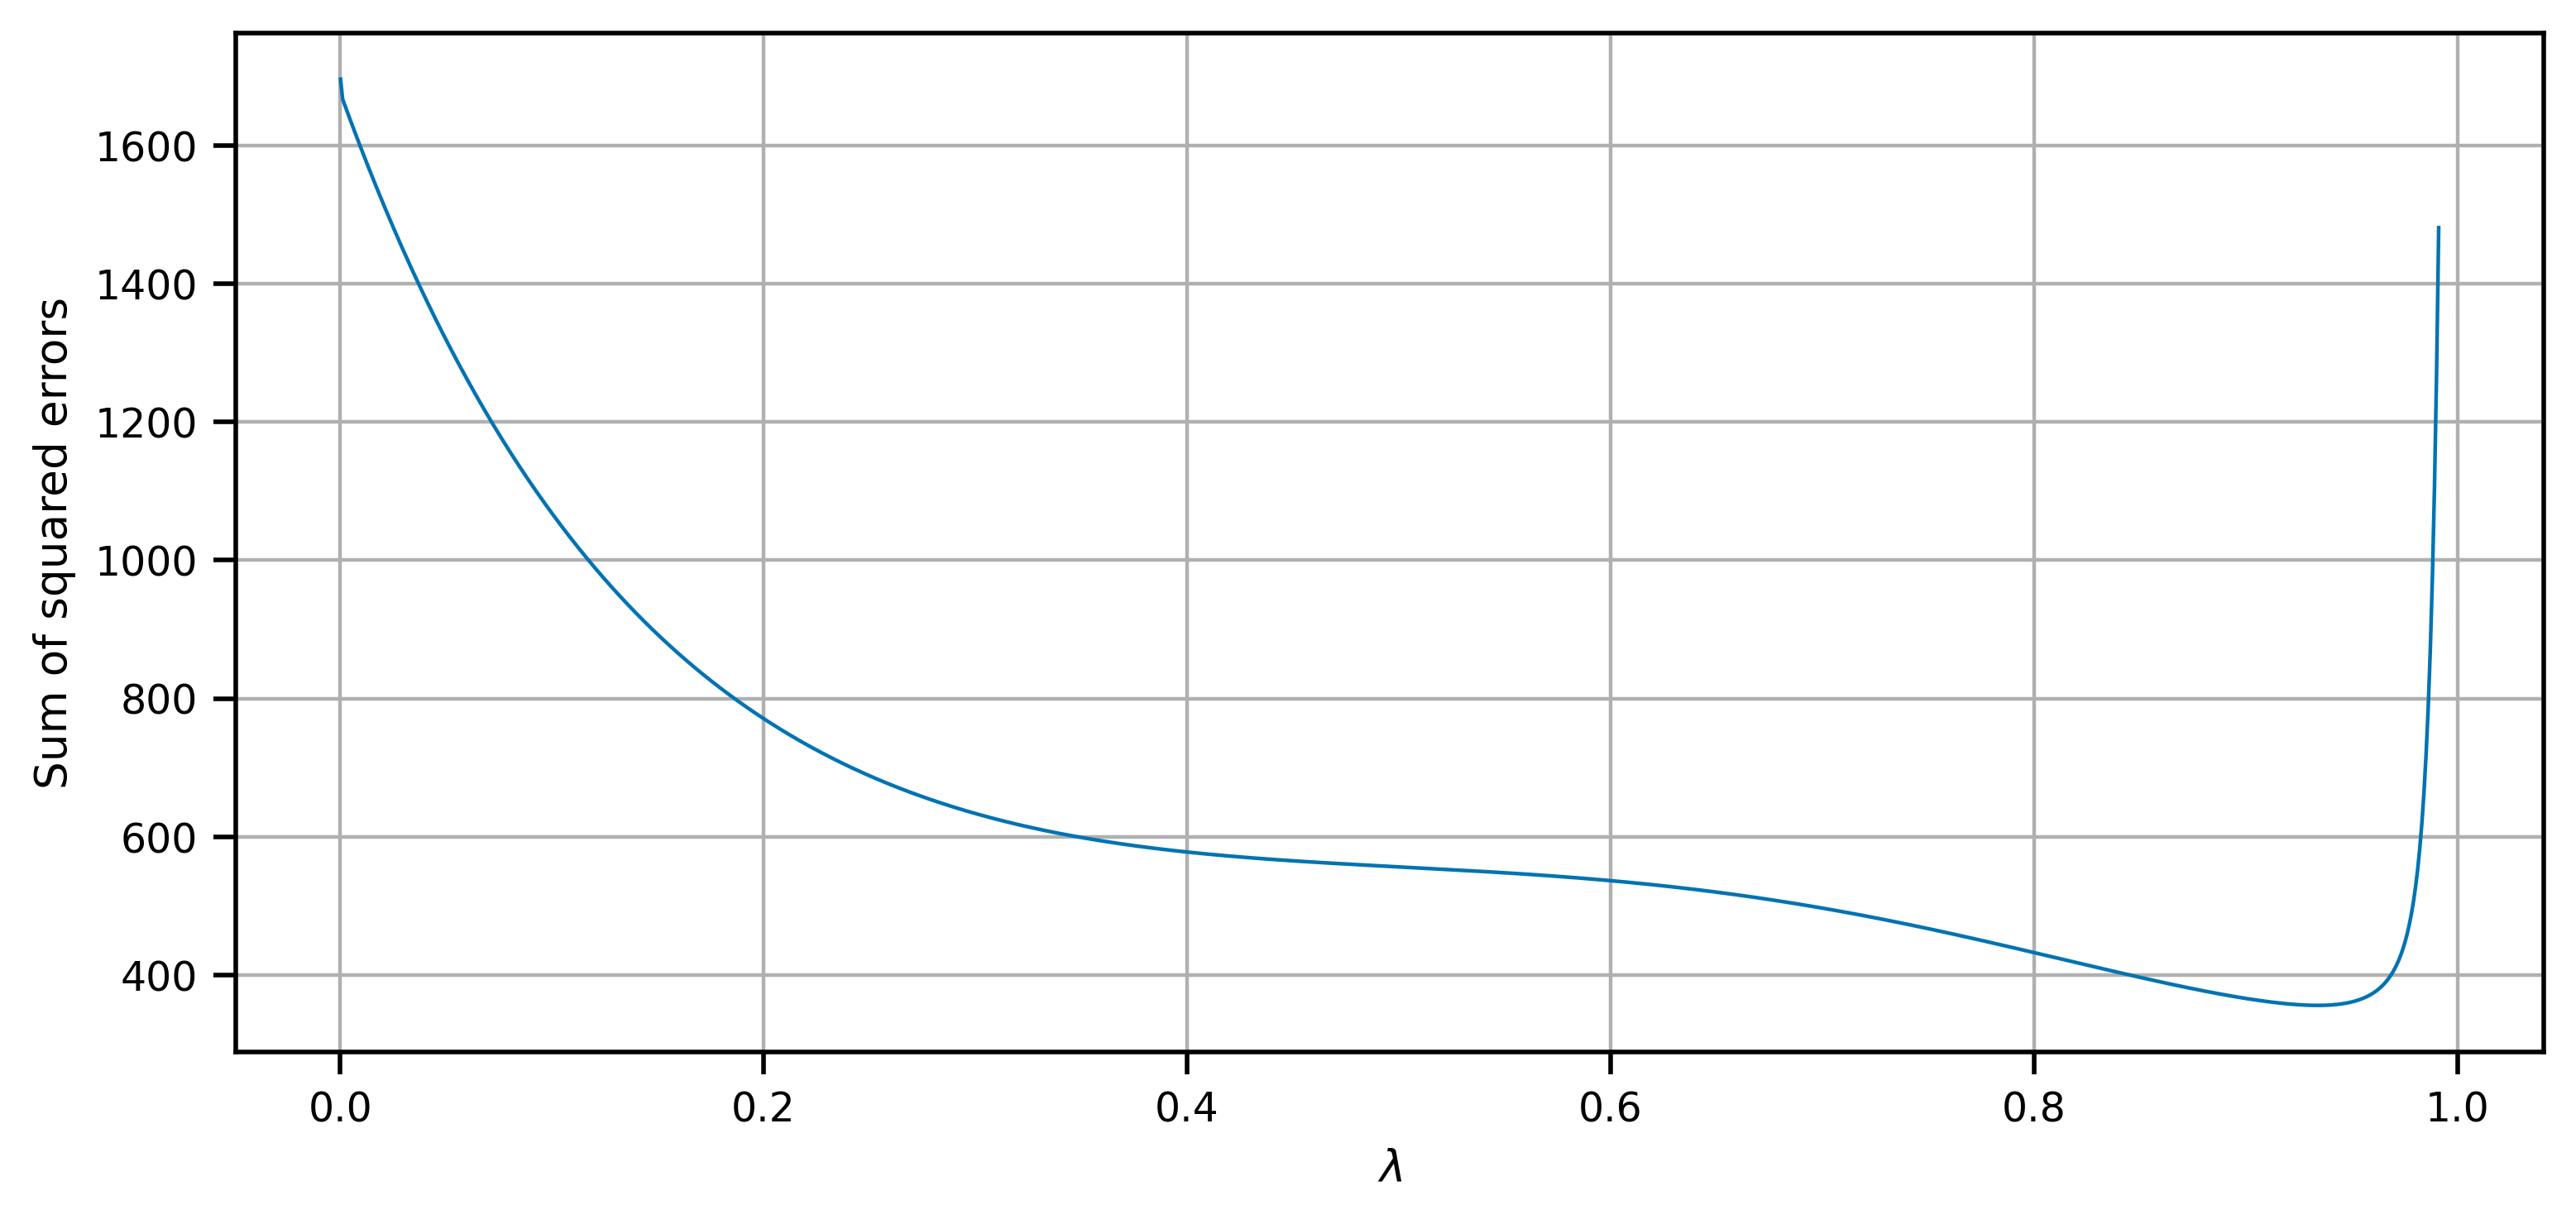

0.933476076076076


In [26]:
# Set ranges of points to skip and lambdas to test
burn_in_2 = 100
lambs = np.linspace(0+2e-4, 1-9e-3, 1000)

# Predict and calculate squared error for each lambda
sqerrors = [((y_train[burn_in_2:, 0] - llt_predict(start=burn_in_2, lamb=l)[0])**2).sum() for l in tqdm(lambs)]

# Plot squared error as a function of lambda
plt.plot(lambs, sqerrors)

plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('Sum of squared errors')

plt.show()

print(lambs[800+np.argmin(sqerrors[800:])])

0.933476076076076
356.2038625197131


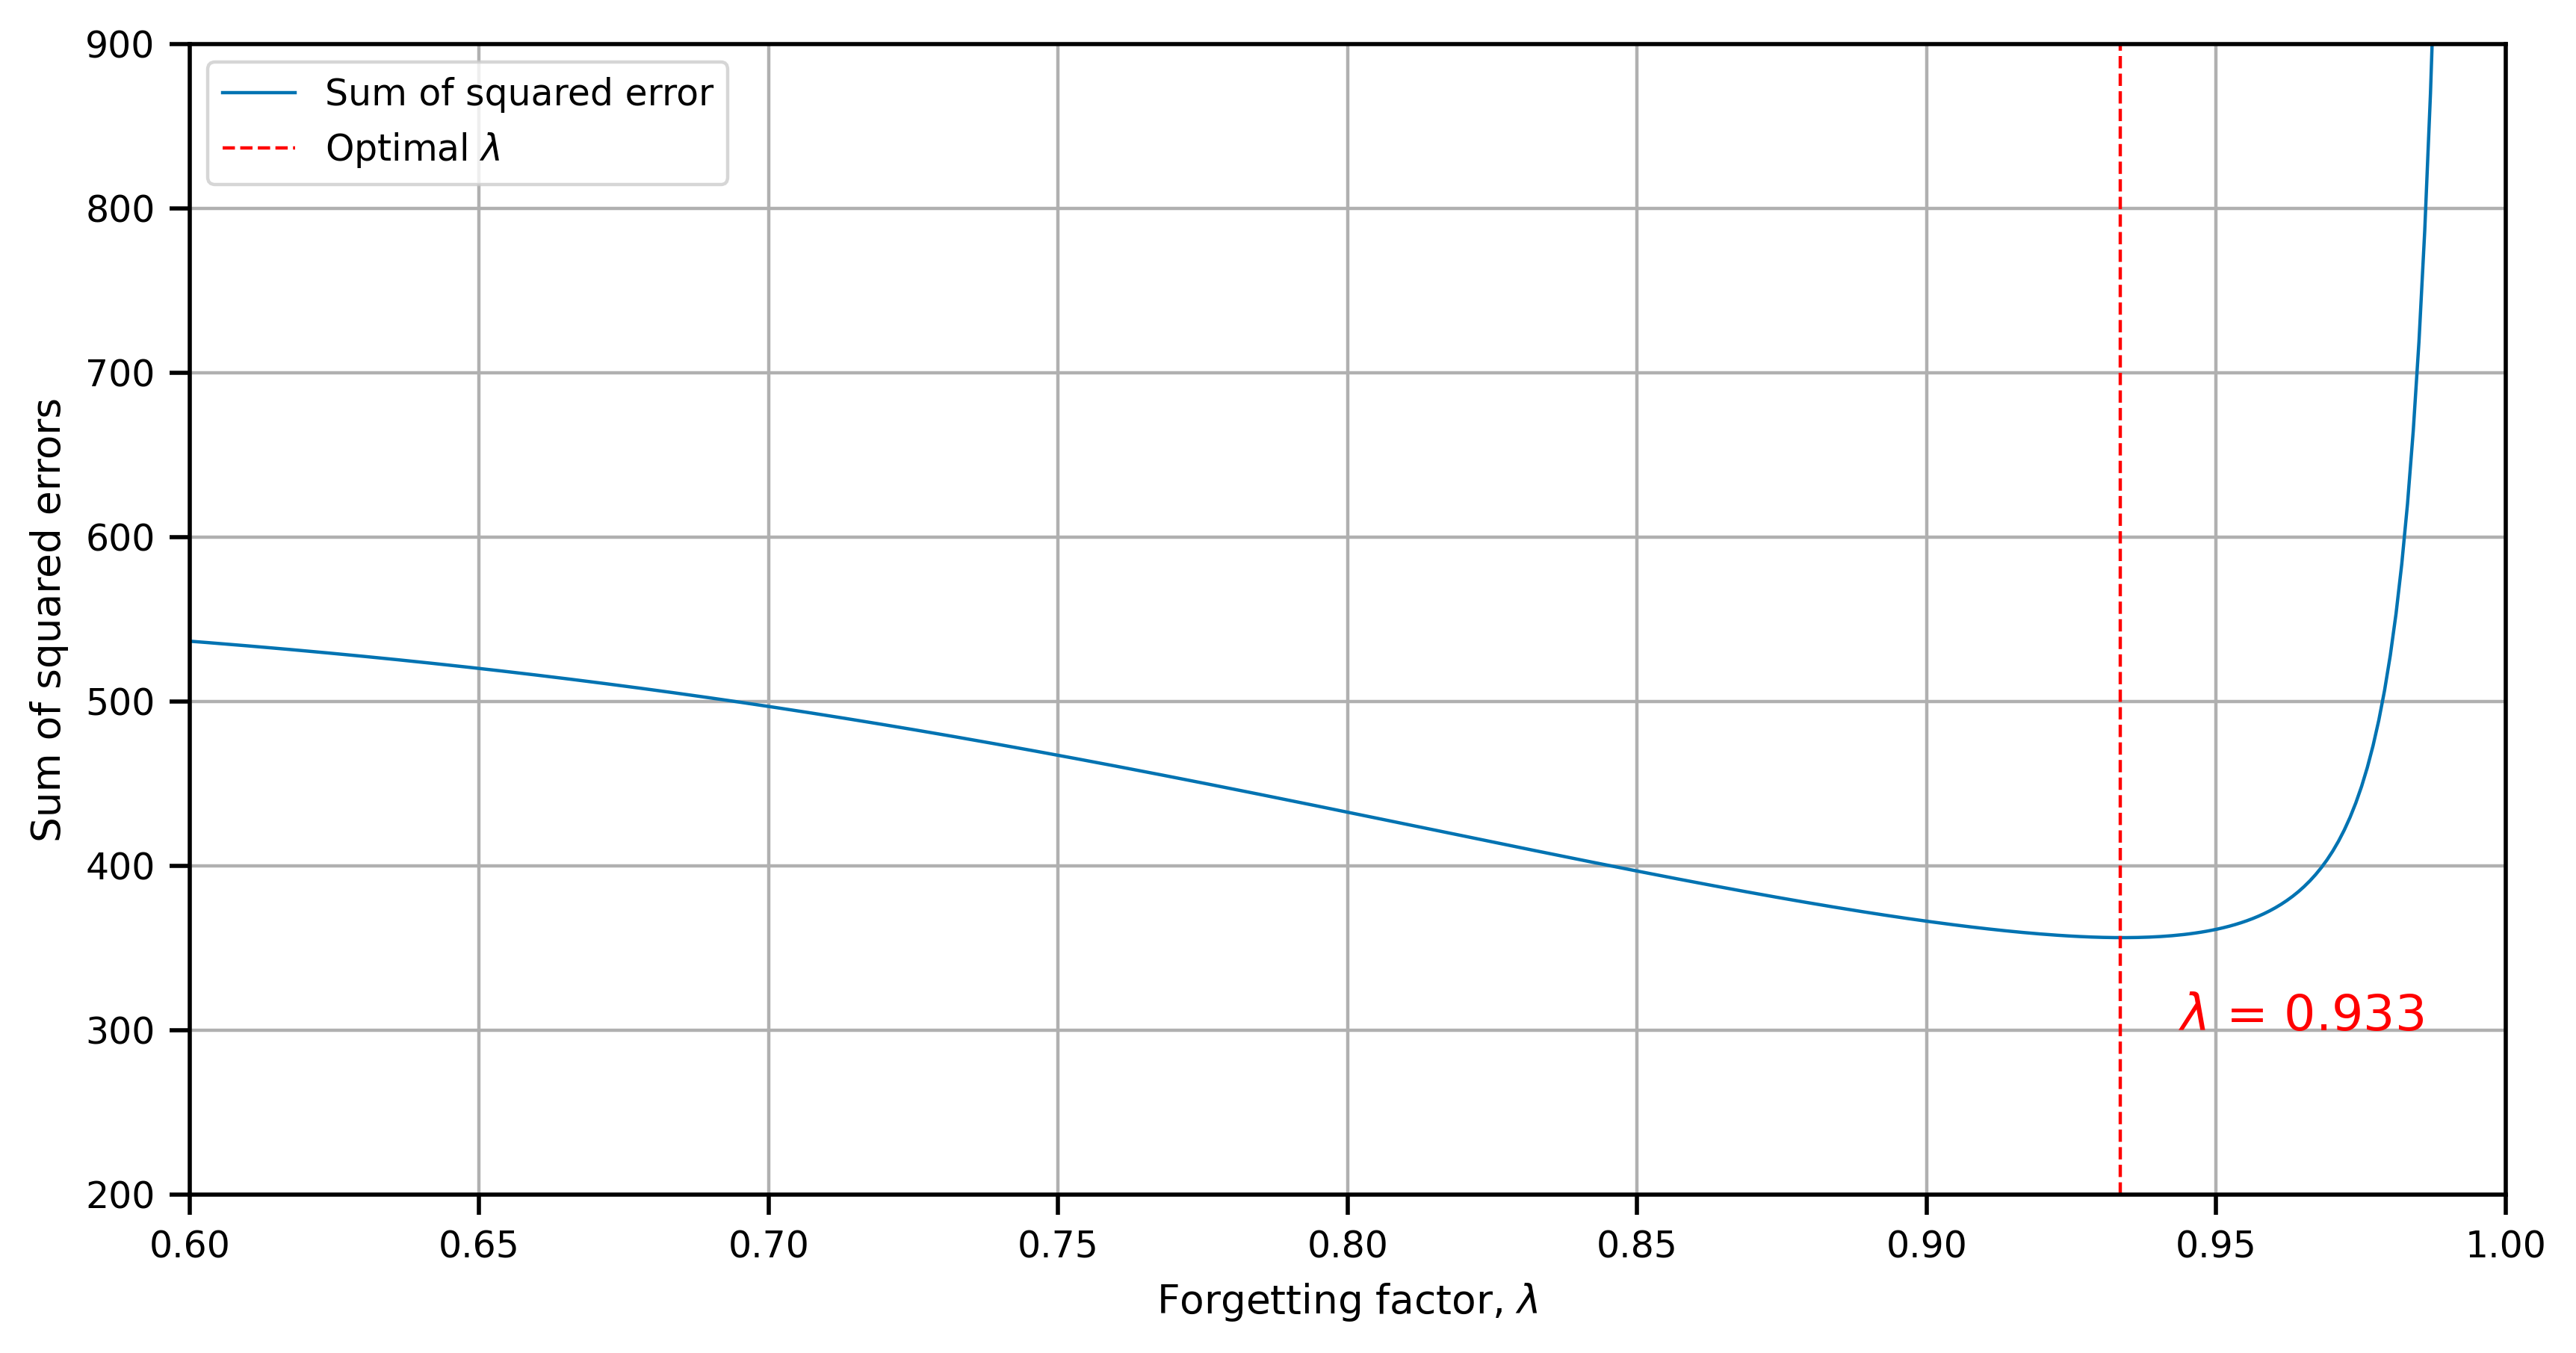

In [27]:
optimal_lambda = lambs[800 + np.argmin(sqerrors[800:])]
print(optimal_lambda)
print(sqerrors[800 + np.argmin(sqerrors[800:])])


fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()

# Plot squared error as a function of lambda
ax.plot(lambs, sqerrors, label="Sum of squared error")
ax.vlines(
    optimal_lambda, 200, 900, color="r", linestyles="dashed", label="Optimal $\lambda$"
)

plt.text(
    optimal_lambda + 0.01,
    300,
    f"$\lambda$ = {optimal_lambda:.3f}",
    color="r",
    fontsize=12,
)

ax.set_xlim(0.6, 1)
ax.set_ylim(200, 900)

ax.set_xlabel("Forgetting factor, $\lambda$")
ax.set_ylabel("Sum of squared errors")
ax.legend()

plt.show()

# 1.1

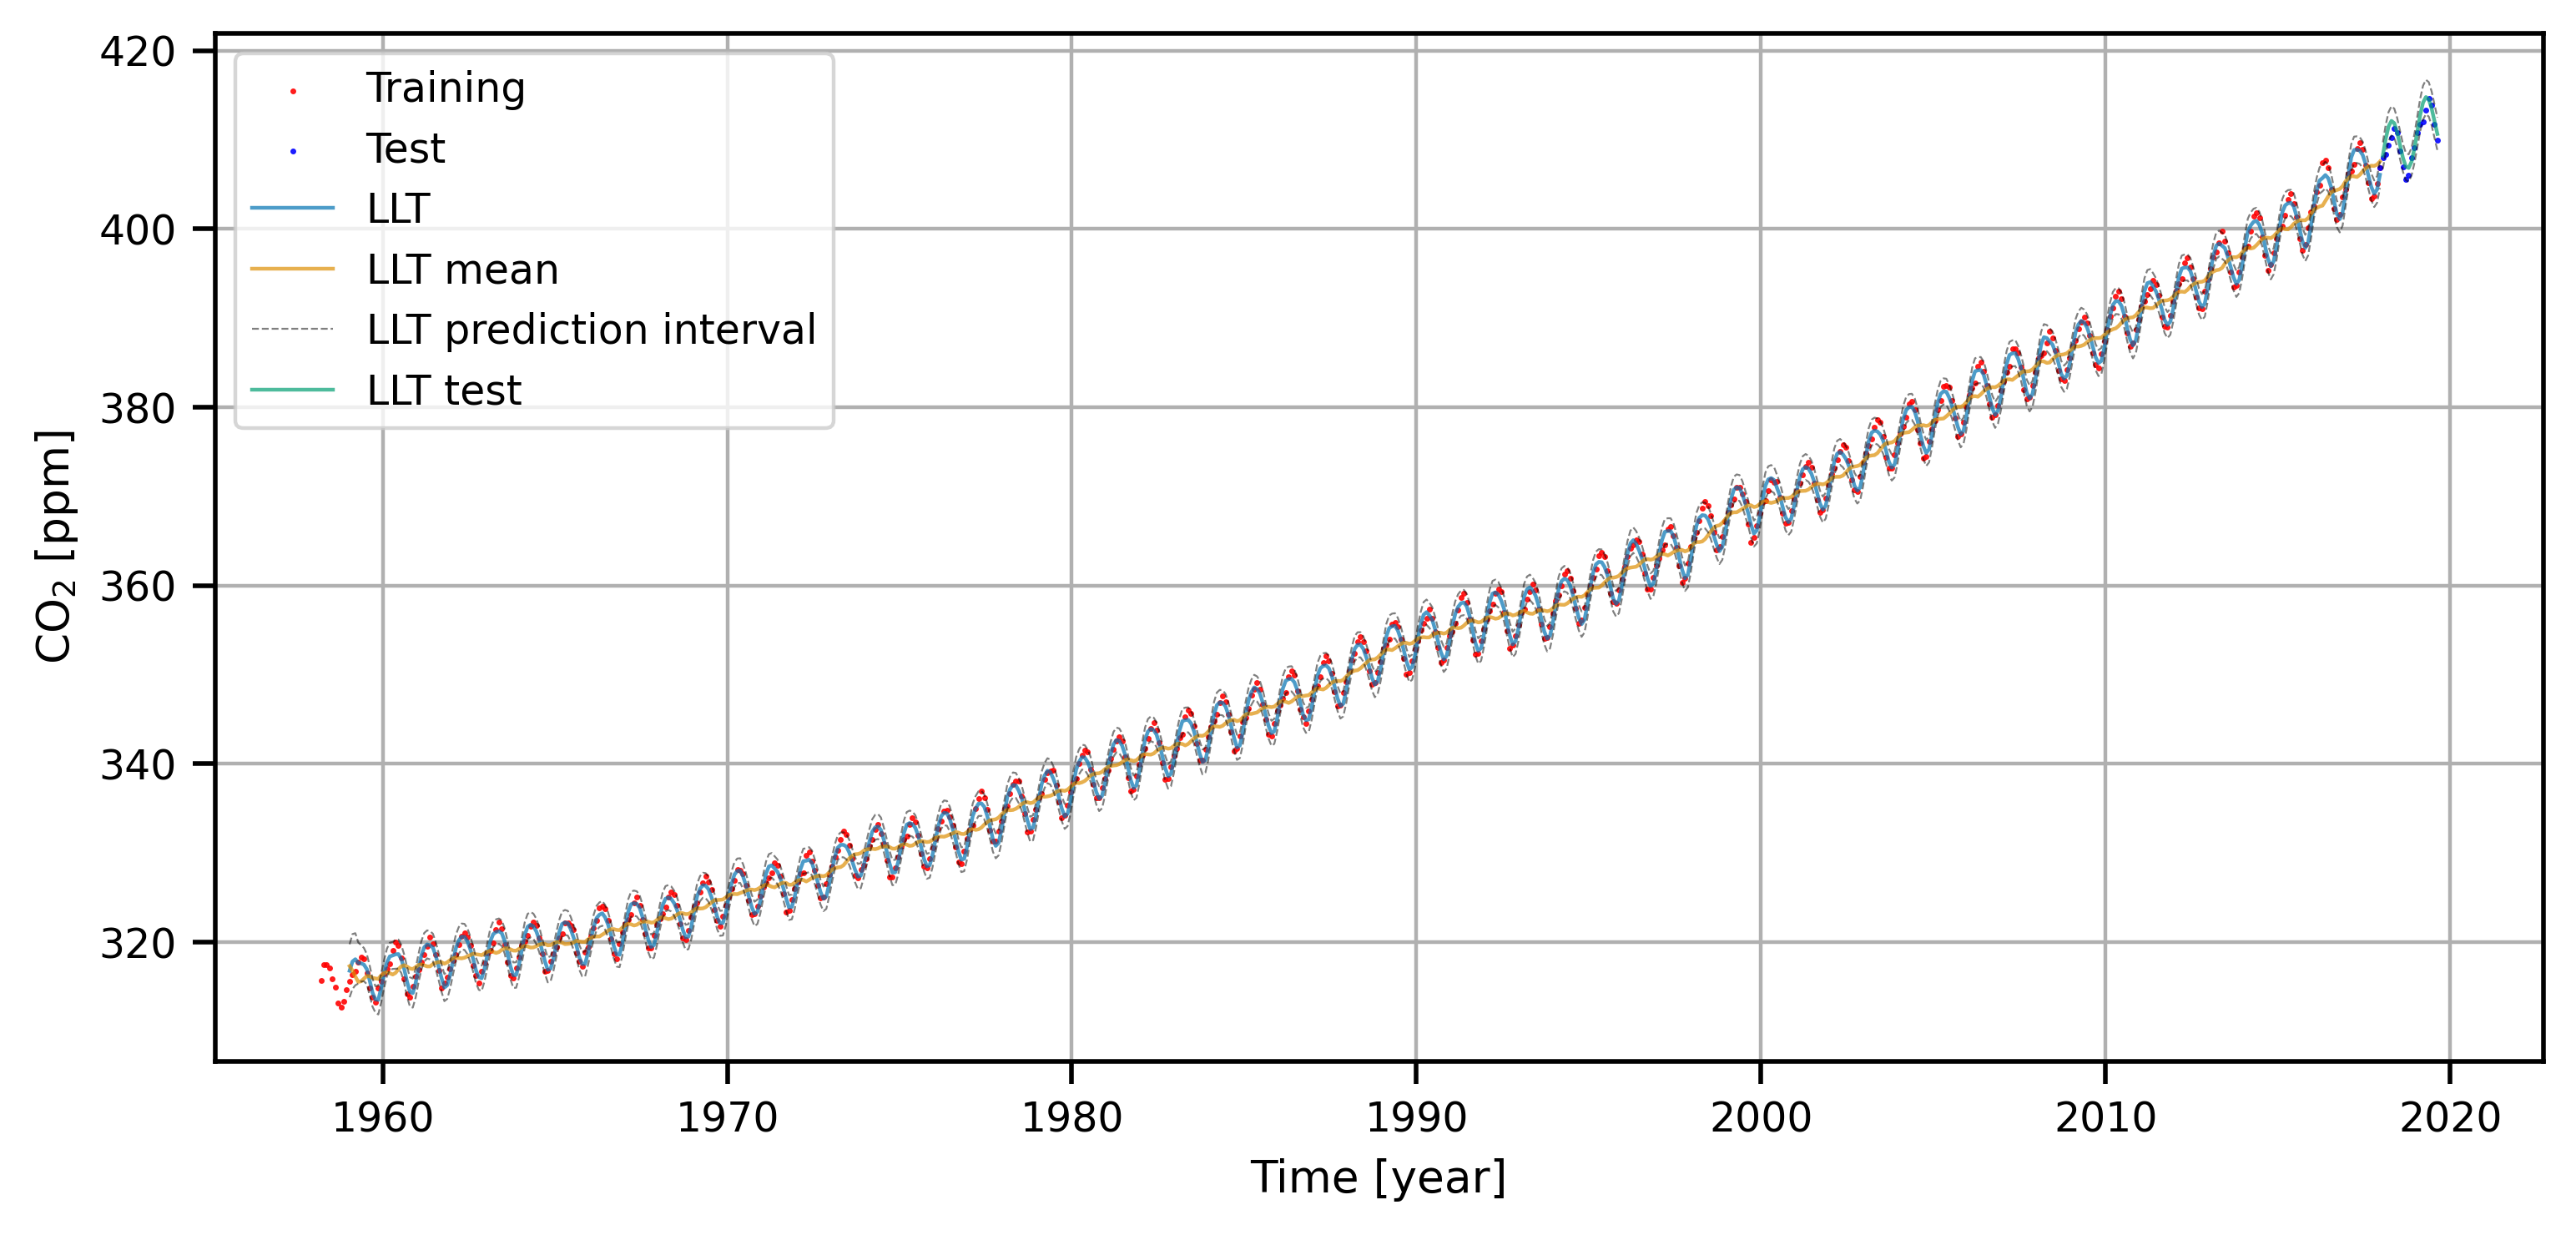

In [28]:
# Set plot options
plot_model_params = {"alpha": 0.7, "linestyle": '-', "linewidth": 0.8}
plot_interval_params = {"alpha": 0.5, "linestyle": '--', "linewidth": 0.4}
plot_data_params = {"alpha": 0.9, "s": 0.2}


# Plot data
plt.scatter(time_train, co2_train, label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[burn_in_1:], llt_y_pred_train, label="LLT", **plot_model_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_mean, label="LLT mean", **plot_model_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_interval[:, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_interval[:, 1], c='k', **plot_interval_params)

plt.plot(time_test, llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)



# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ [ppm]")

plt.legend()
plt.grid()

plt.show()


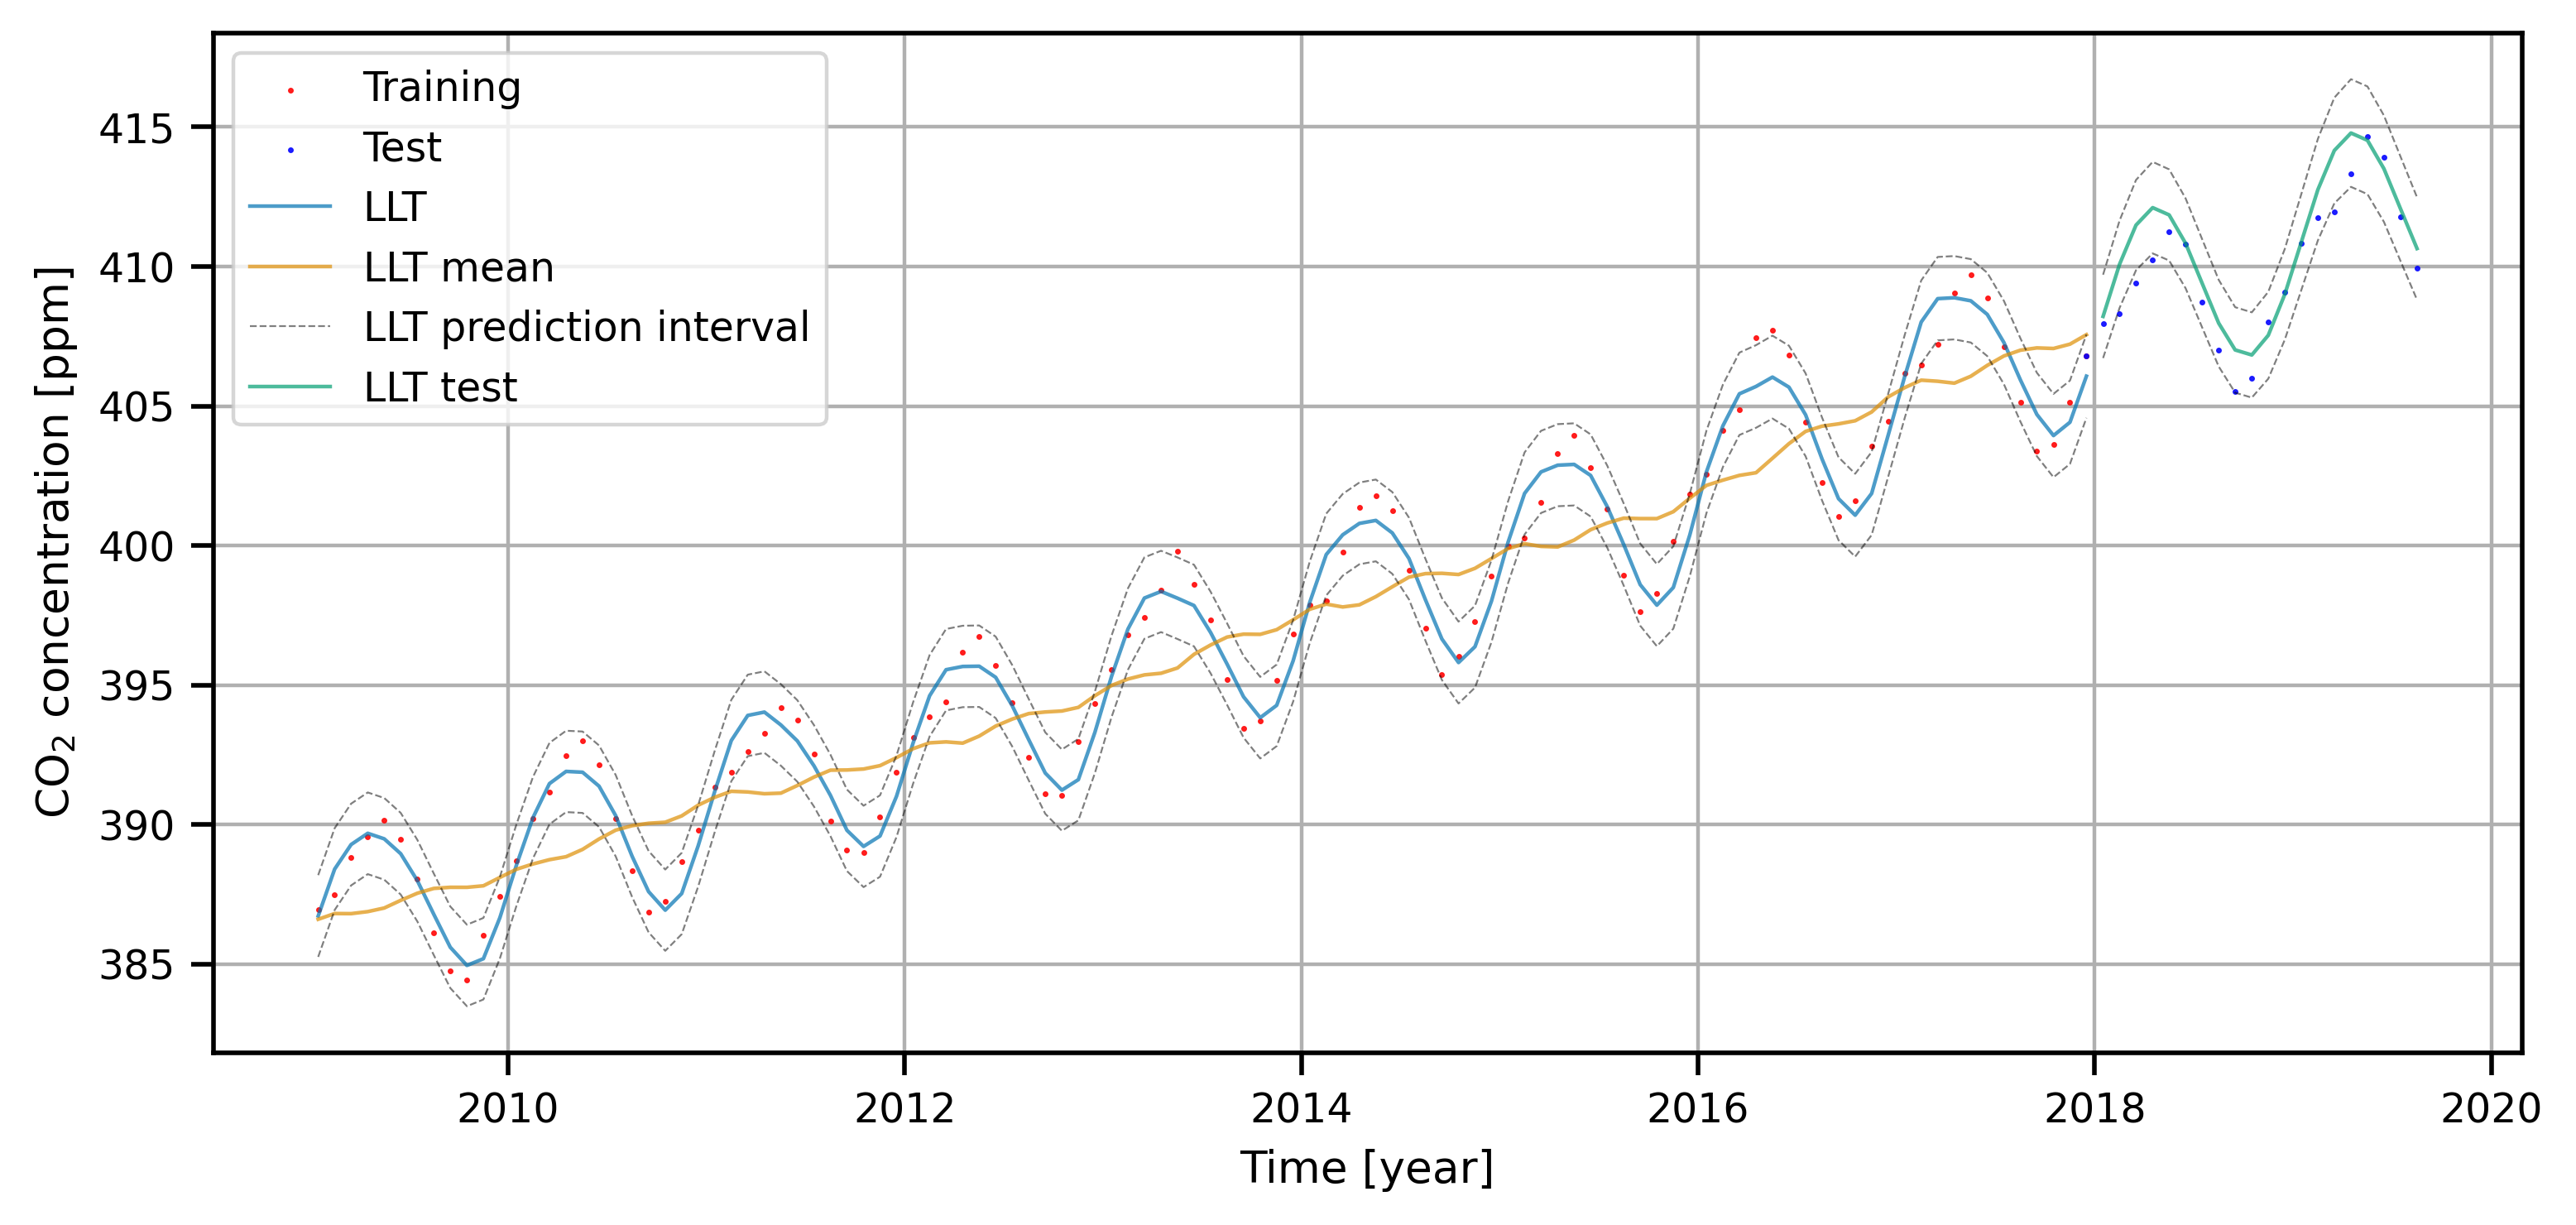

In [29]:
zoom_idx = np.argwhere(year[~test_idx] >= 2009).squeeze()

# Plot data
plt.scatter(time_train[zoom_idx], co2_train[zoom_idx], label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[zoom_idx], llt_y_pred_train[zoom_idx-burn_in_1], label="LLT", **plot_model_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_mean[zoom_idx-burn_in_1], label="LLT mean", **plot_model_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_interval[zoom_idx-burn_in_1, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_interval[zoom_idx-burn_in_1, 1], c='k', **plot_interval_params)

plt.plot(time_test, llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)


# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ concentration [ppm]")

plt.legend()
plt.grid()

plt.show()

In [30]:
# Print table of future predictions
y_pred_test_idx = np.array([1, 2, 6, 12, 20])-1

for t, true, pred, lower, upper in zip(y_pred_test_idx+1, co2_test[y_pred_test_idx], llt_y_pred_test[y_pred_test_idx, 0], llt_y_pred_test_interval[y_pred_test_idx, 1], llt_y_pred_test_interval[y_pred_test_idx, 0]):
    print(f"{t} & {true:.2f} & {pred:.2f} & {lower:.2f} & {upper:.2f}\\\\")

1 & 407.96 & 408.21 & 406.72 & 409.71\\
2 & 408.32 & 410.08 & 408.51 & 411.64\\
6 & 410.79 & 410.83 & 409.22 & 412.44\\
12 & 409.07 & 409.00 & 407.37 & 410.62\\
20 & 409.95 & 410.64 & 408.81 & 412.48\\


# Question 1.4.2

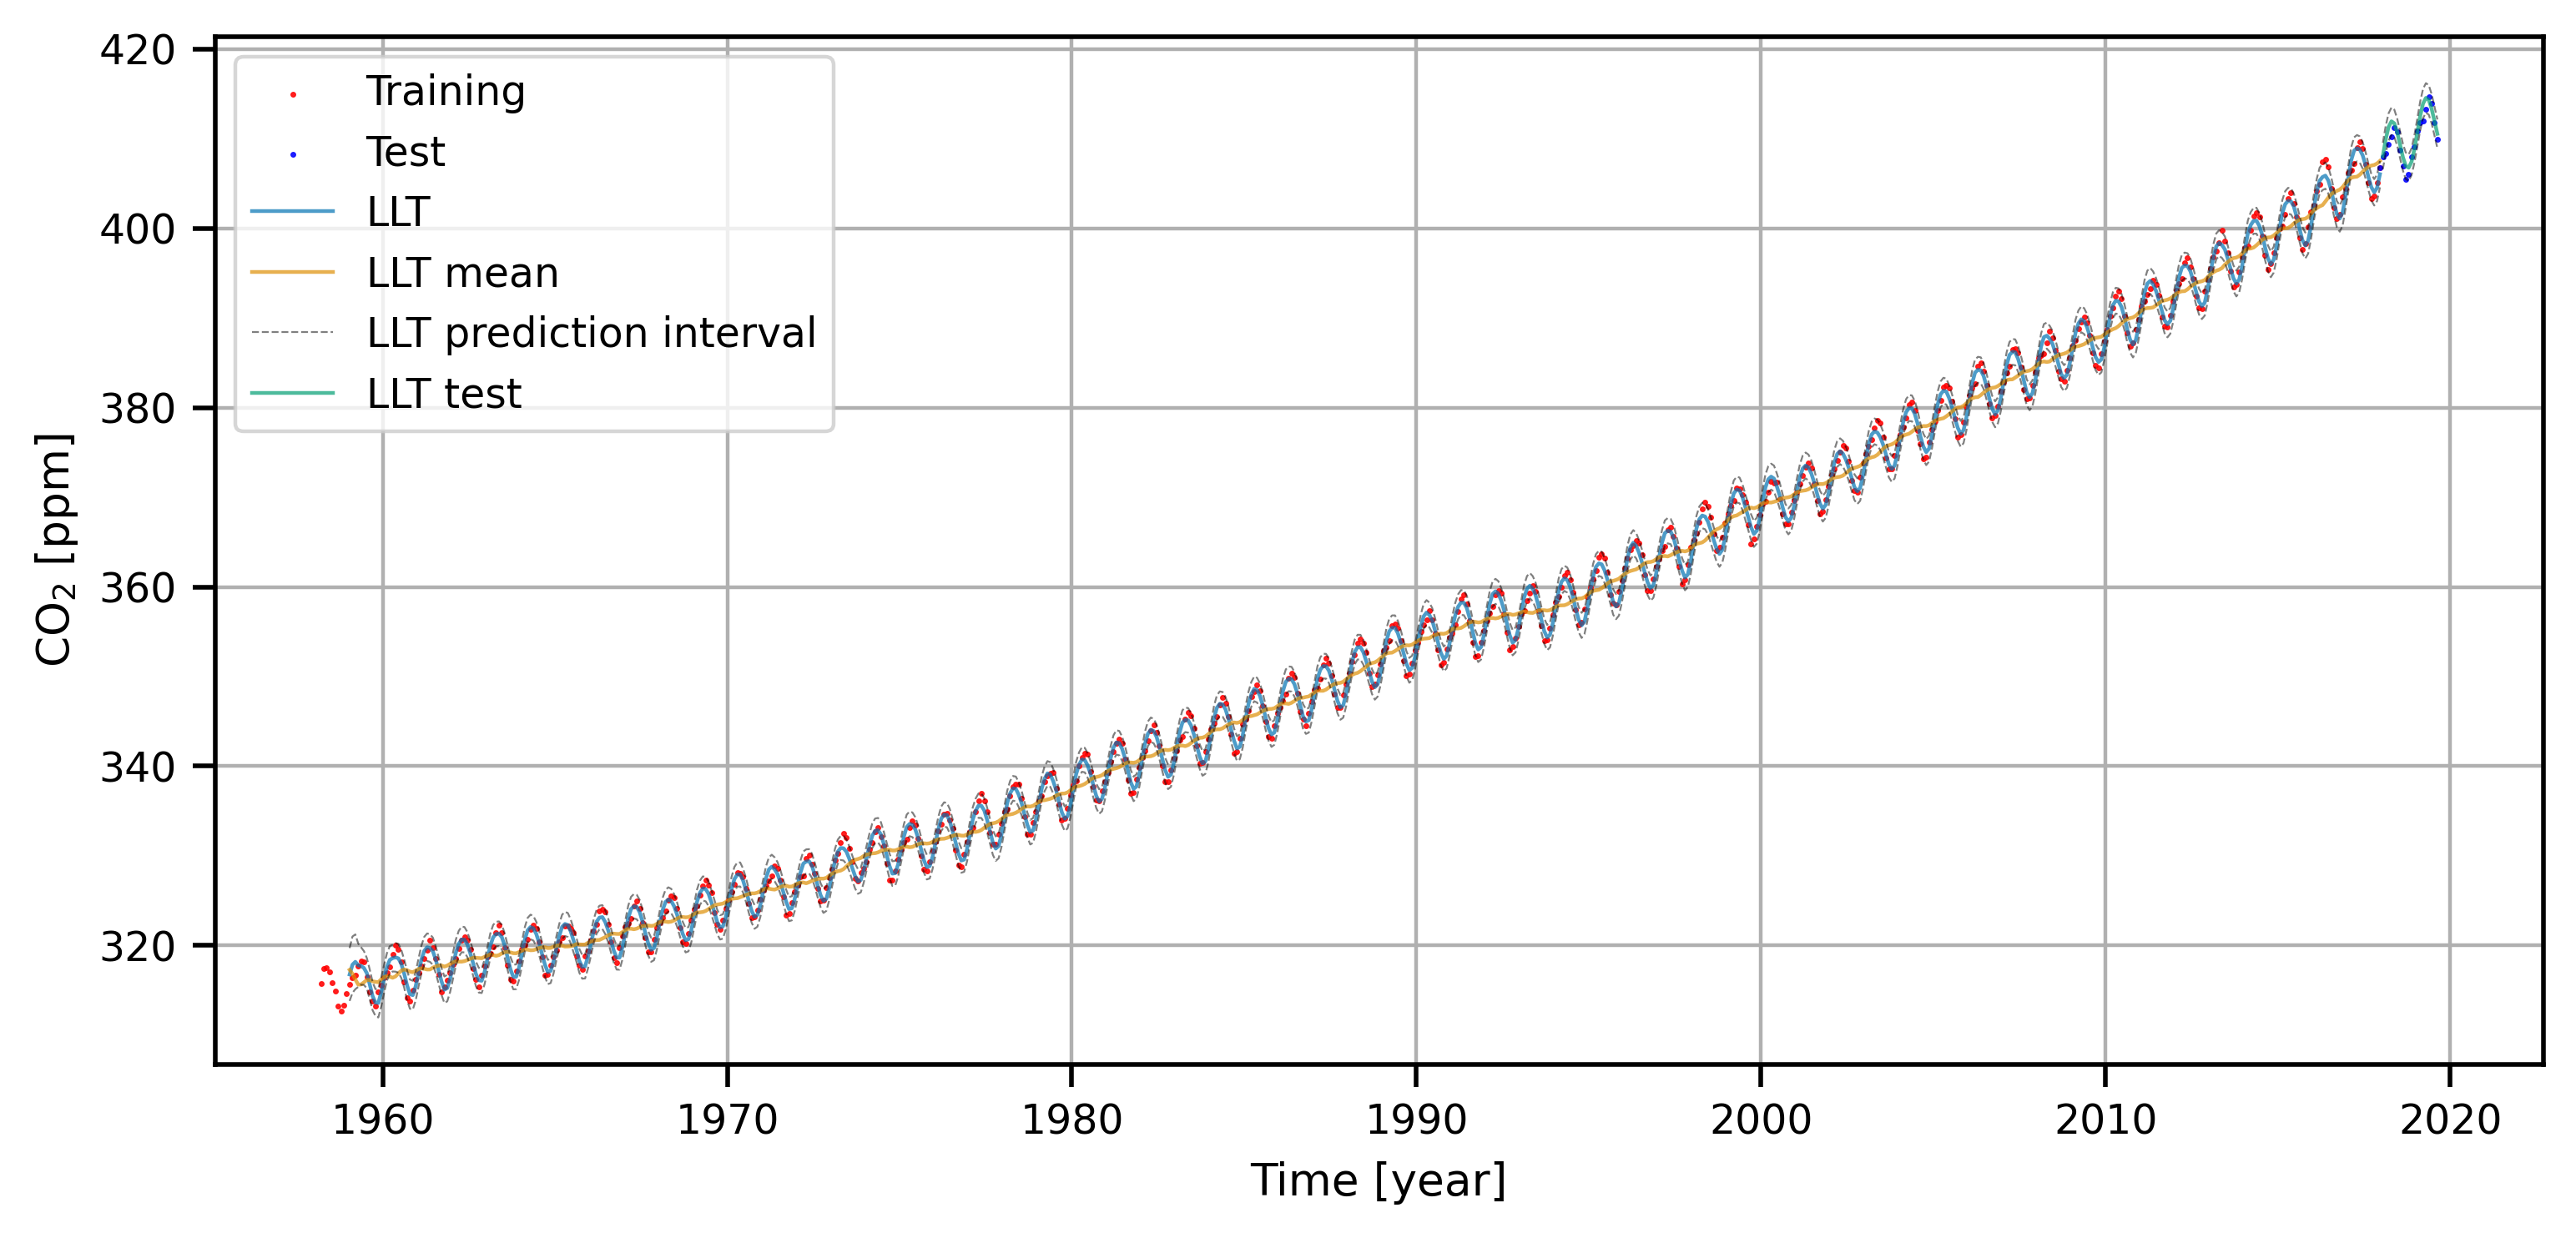

In [31]:
BURN_IN = 10
optimal_llt_y_pred_train, optimal_llt_y_pred_train_interval, optimal_llt_y_pred_train_mean, optimal_llt_y_pred_train_var, optimal_llt_y_pred_test, optimal_llt_y_pred_test_interval = llt_predict(start = BURN_IN, lamb = optimal_lambda)

# Set plot options
plot_model_params = {"alpha": 0.7, "linestyle": '-', "linewidth": 0.8}
plot_interval_params = {"alpha": 0.5, "linestyle": '--', "linewidth": 0.4}
plot_data_params = {"alpha": 0.9, "s": 0.2}


# Plot data
plt.scatter(time_train, co2_train, label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[BURN_IN:], optimal_llt_y_pred_train, label="LLT", **plot_model_params)
plt.plot(time_train[BURN_IN:], optimal_llt_y_pred_train_mean, label="LLT mean", **plot_model_params)
plt.plot(time_train[BURN_IN:], optimal_llt_y_pred_train_interval[:, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[BURN_IN:], optimal_llt_y_pred_train_interval[:, 1], c='k', **plot_interval_params)

plt.plot(time_test, optimal_llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, optimal_llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, optimal_llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)


# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ [ppm]")

plt.legend()
plt.grid()

plt.show()


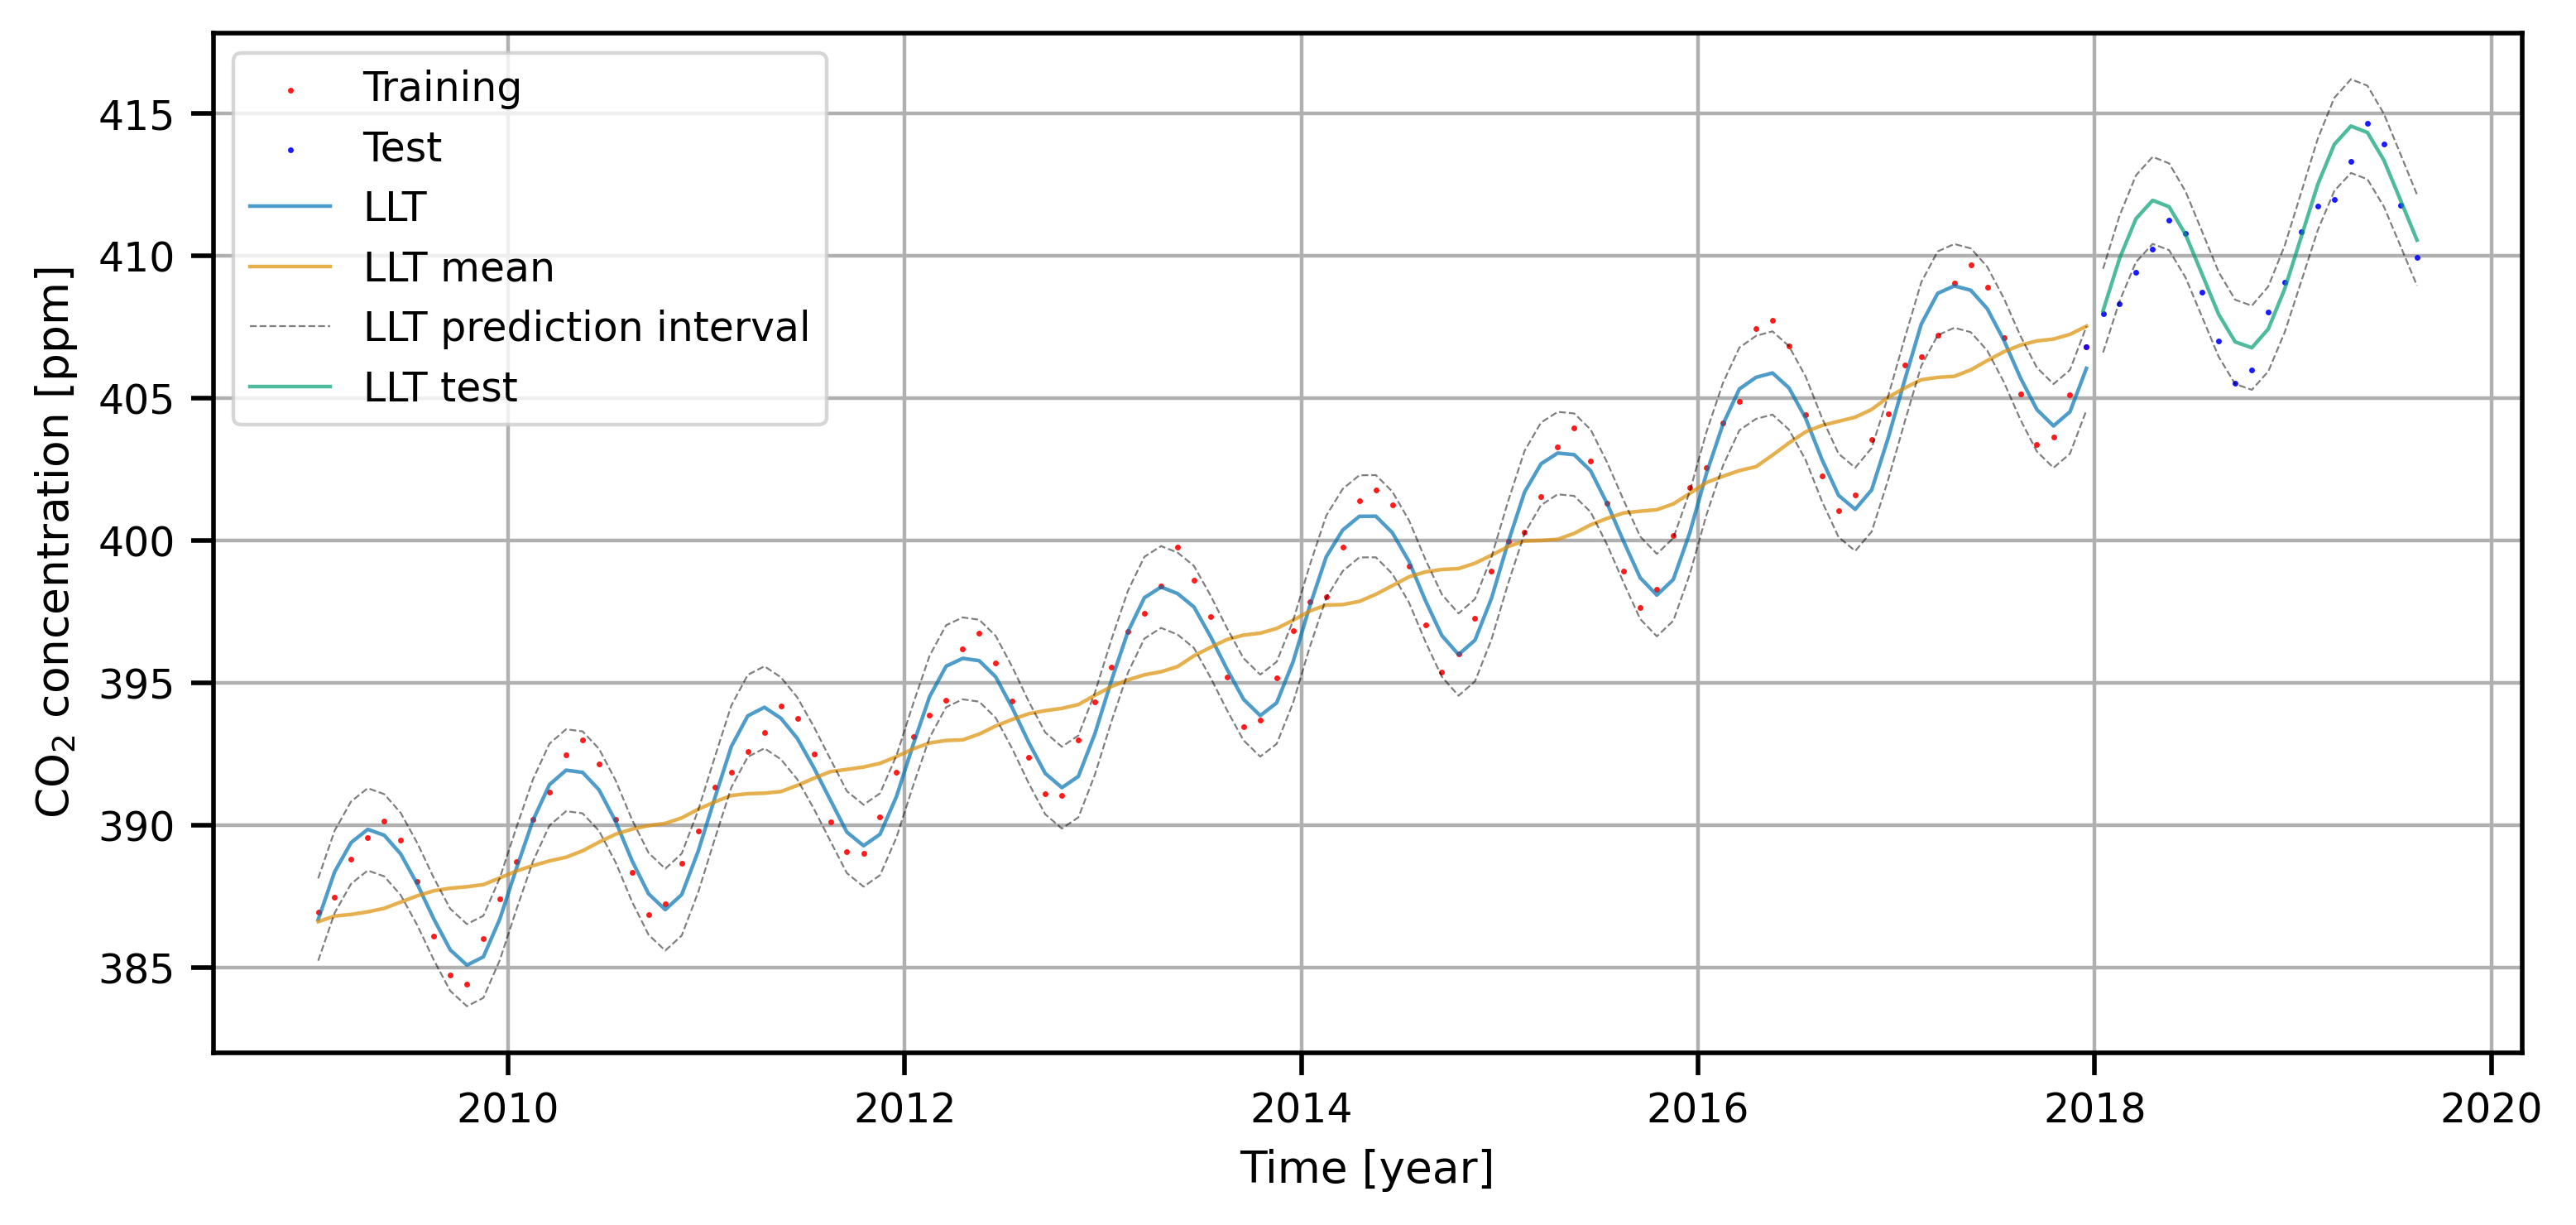

In [32]:
zoom_idx = np.argwhere(year[~test_idx] >= 2009).squeeze()

# Plot data
plt.scatter(time_train[zoom_idx], co2_train[zoom_idx], label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[zoom_idx], optimal_llt_y_pred_train[zoom_idx-BURN_IN], label="LLT", **plot_model_params)
plt.plot(time_train[zoom_idx], optimal_llt_y_pred_train_mean[zoom_idx-BURN_IN], label="LLT mean", **plot_model_params)
plt.plot(time_train[zoom_idx], optimal_llt_y_pred_train_interval[zoom_idx-BURN_IN, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[zoom_idx], optimal_llt_y_pred_train_interval[zoom_idx-BURN_IN, 1], c='k', **plot_interval_params)

plt.plot(time_test, optimal_llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, optimal_llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, optimal_llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)


# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ concentration [ppm]")

plt.legend()
plt.grid()

plt.show()

In [33]:
# Print table of future predictions
y_pred_test_idx = np.array([1, 2, 6, 12, 20])-1

for t, true, pred, lower, upper in zip(y_pred_test_idx+1, co2_test[y_pred_test_idx], optimal_llt_y_pred_test[y_pred_test_idx, 0], optimal_llt_y_pred_test_interval[y_pred_test_idx, 1], optimal_llt_y_pred_test_interval[y_pred_test_idx, 0]):
    print(f"{t} & {true:.2f} &{pred:.2f} & {lower:.2f} & {upper:.2f}\\\\")

1 & 407.96 &408.07 & 406.60 & 409.54\\
2 & 408.32 &409.90 & 408.40 & 411.41\\
6 & 410.79 &410.74 & 409.23 & 412.25\\
12 & 409.07 &408.84 & 407.32 & 410.36\\
20 & 409.95 &410.54 & 408.95 & 412.14\\
